In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [2]:
import sklearn
import pandas
import numpy as np
import sklearn
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, cross_val_predict,cross_val_score,cross_validate
from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV
from sklearn.preprocessing import LabelEncoder

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
train_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

## EDA

Input variables:  
1 last contact date: last contact date  
2 age (numeric)  
3 job : type of job  
4 marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
5 education (categorical: "unknown","secondary","primary","tertiary")  
6 default: has credit in default? (binary: "yes","no")  
7 balance: average yearly balance, in euros (numeric)  
8 housing: has housing loan? (binary: "yes","no")  
9 loan: has personal loan? (binary: "yes","no")  
10 contact: contact communication type (categorical: "unknown","telephone","cellular")  
11 duration: last contact duration, in seconds (numeric)  
12 campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
13 pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
14 previous: number of contacts performed before this campaign and for this client (numeric)  
15 poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")  

Output variable (desired target):  
16 target: has the client subscribed a term deposit? (binary: "yes","no")  

In [5]:
train_eda=train_data.copy() # perfrom eda on the copied dataset

In [6]:
#read the dataset
print(pd.DataFrame(train_eda.info()))
print(pd.DataFrame(train_eda.describe()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [7]:
categorical_columns=train_eda.select_dtypes('object').columns
numerical_columns=train_eda.select_dtypes('int').columns
print('categorical features:',categorical_columns, 'numerical features:',numerical_columns)

categorical features: Index(['last contact date', 'job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'poutcome', 'target'],
      dtype='object') numerical features: Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


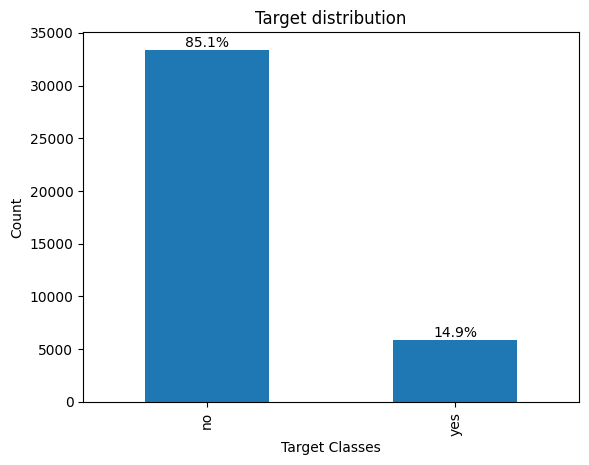

In [8]:
# Is the data imbalanced?
#check the target
target_distri=train_eda['target'].value_counts()
ax=target_distri.plot.bar()
plt.title("Target distribution")

total_count=target_distri.sum()
for p in ax.patches:
    height=p.get_height()
    percentage=(height/total_count) * 100
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom')

plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.show()

<span style="color:red">The data is highly imbalanced :( </span>

#### Missing data distribution

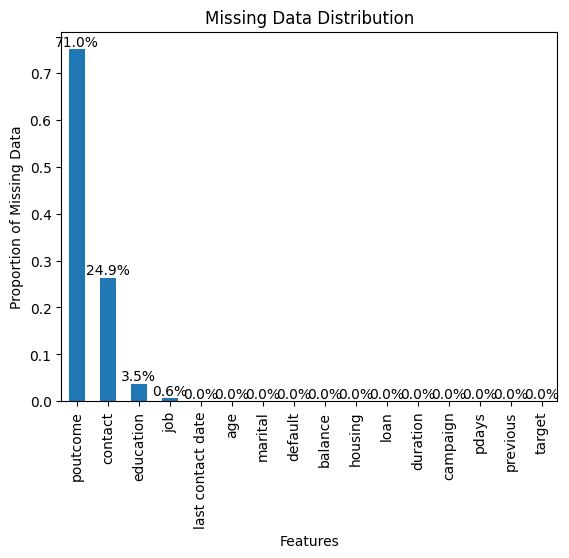

In [9]:
import matplotlib.pyplot as plt

missing_distri = (train_eda.isna().sum() / train_eda.shape[0]).sort_values(ascending=False)

ax = missing_distri.plot.bar()
plt.title('Missing Data Distribution')

total_count = missing_distri.sum()

for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom')

# Set labels and show the plot
plt.xlabel('Features')
plt.ylabel('Proportion of Missing Data')
plt.show()

### univariate analysis

#### Categorical analysis

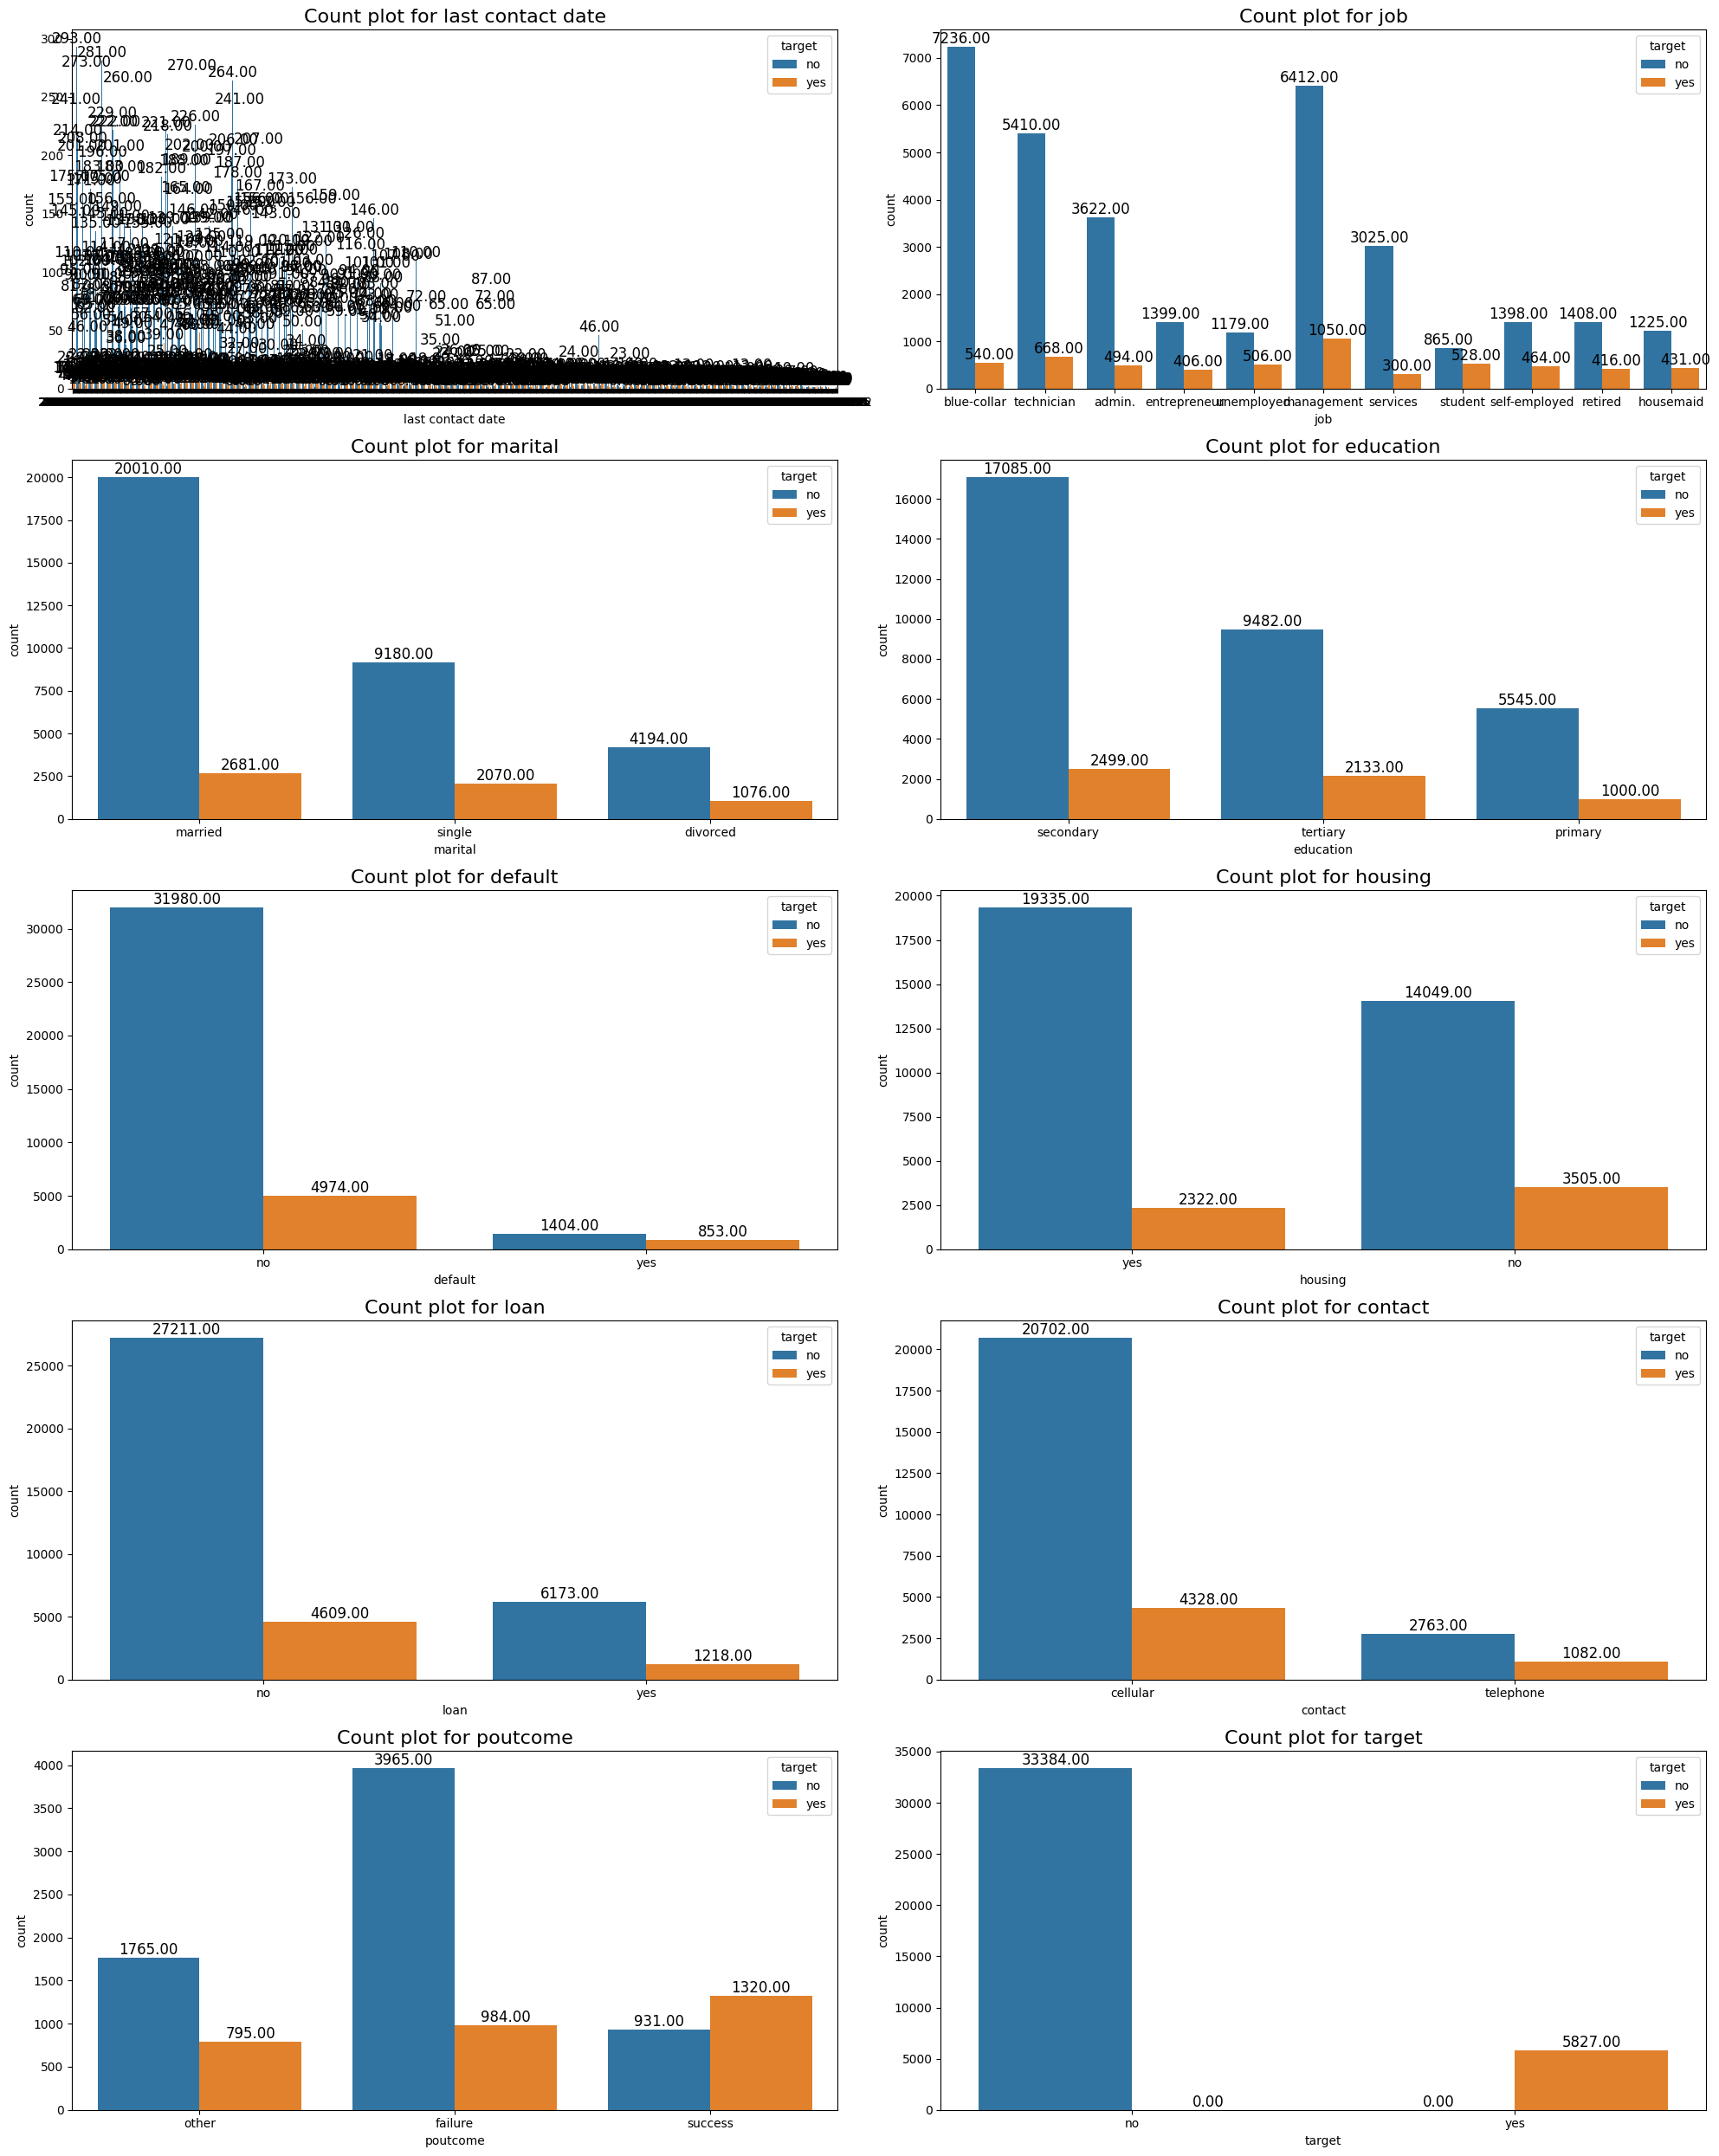

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def feature_countplot(ax, x):
    sns.countplot(data=train_eda, x=x, hue="target", ax=ax)
    for p in ax.patches:
        count = p.get_height()
        ax.annotate(f'{count:.2f}', (p.get_x() + p.get_width() / 2., count), 
                    ha='center', va='bottom', fontsize=12, color='black', 
                    rotation=0)



ncols = 2
nrows = (len(categorical_columns) + 1) // ncols


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flatten()

for i, feature in enumerate(categorical_columns):
    feature_countplot(axes[i], feature)
    axes[i].set_title(f'Count plot for {feature}', fontsize=16)

if len(categorical_columns) % ncols != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

**Categorical Insights**  
<div style="font-family:Verdana, sans-serif; color:blue;"> 
<li><u>job</u>: 11 categories , <b>blue-collar</b> and <b>management job</b> -  highest rate of negative responses </li>  
management - highest rate of positive responses
<li><u>marital</u> - 3 categories, 58% married, out of them, 90% negative response</li>
<li><u>education</u>- 3 categories, majority of them have secondary education and negative responses</li>
Note: education and marital have a somewhat <i>similar</i> chart  
<li><u>default</u>- around 95 percent of the clients do not have a credit default and out of these around 90 percent do not subscribe to the term deposit</li>
<li><u>housing</u>- Slighlty even distribution b/w yes and no, although, in both yes and no, majority are not subscribed</li>
<li><u>loan</u>- 80 percent dont have a loan, majority on both sides, not subscribed</li>
<li><u>contact</u>- 2 categories , 25 percent values missing, 90 percent cellular</li>
<li><u> poutcome</u>- 3 categories, 75 percent values missing, majority failure</li>
</div>

#### bivariate categorical analysis

In [11]:
pd.crosstab(train_eda['marital'],train_eda['education'])


education  primary  secondary  tertiary
marital                                
divorced       955       2649      1527
married       4557      11288      5933
single        1033       5647      4155

#### Numerical Analysis

In [12]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

def kmeans_binning(df, column_name, n_bins=4):
    """
    K-means binning method.
    """
    balance_values = df[column_name].dropna().values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_bins, random_state=0).fit(balance_values)
    sorted_centroids = sorted(kmeans.cluster_centers_.flatten())
    bin_edges = [df[column_name].min()] + sorted_centroids + [df[column_name].max()]
    
    return bin_edges


def decision_tree_binning(df, column_name, n_bins=4):
    """
    Decision Tree-based binning method.
    """
    balance_values = df[column_name].dropna().values.reshape(-1, 1)
    decision_tree = DecisionTreeRegressor(max_leaf_nodes=n_bins, random_state=0)
    decision_tree.fit(balance_values, np.zeros_like(balance_values))  # Fit a dummy target
    bin_edges = np.sort(decision_tree.apply(balance_values).flatten())
    
    # Convert leaf node values to actual bin edges
    bin_edges = np.unique(np.concatenate(([df[column_name].min()], bin_edges, [df[column_name].max()])))
    
    return bin_edges

def analyze_for_binning(df, column_name):
    """
    Analyze the column for binning with K-means and Decision Tree-based binning.
    """
    stats_dict = {
        'count': len(df[column_name]),
        'missing': df[column_name].isnull().sum(),
        'min': df[column_name].min(),
        'max': df[column_name].max(),
        'mean': df[column_name].mean(),
        'median': df[column_name].median(),
        'std': df[column_name].std(),
        'skew': df[column_name].skew()
    }
    
    percentiles = [0, 1, 5, 10, 25, 50, 75, 90, 95, 99, 100]
    for p in percentiles:
        stats_dict[f'percentile_{p}'] = np.percentile(df[column_name], p)
    
    # Calculate frequency of unique values
    value_counts = df[column_name].value_counts()
    stats_dict['unique_values'] = len(value_counts)
    stats_dict['top_5_common_values'] = value_counts.head().to_dict()
    
    # Method 1: Quartile-based bins
    q1, q2, q3 = np.percentile(df[column_name], [25, 50, 75])
    stats_dict['quartile_based_bins'] = {
        'boundaries': [df[column_name].min(), q1, q2, q3, df[column_name].max()]
    }
    
    # Method 2: Equal-width bins (Sturges' formula)
    n_bins = int(np.ceil(np.log2(len(df))) + 1)
    bin_width = (df[column_name].max() - df[column_name].min()) / n_bins
    equal_width_bins = [df[column_name].min() + i * bin_width for i in range(n_bins + 1)]
    stats_dict['equal_width_bins'] = {
        'n_bins': n_bins,
        'bin_width': bin_width,
        'boundaries': equal_width_bins
    }
    
    # Method 3: Logarithmic bins (if skewed)
    if stats_dict['skew'] > 1:
        log_bounds = np.exp(np.linspace(np.log(df[column_name].min() + 1), np.log(df[column_name].max()), 5))
        stats_dict['distribution_based_bins'] = {'boundaries': log_bounds.tolist(), 'type': 'logarithmic'}
    else:
        mean = df[column_name].mean()
        std = df[column_name].std()
        stats_dict['distribution_based_bins'] = {
            'boundaries': [df[column_name].min(), mean - std, mean, mean + std, df[column_name].max()],
            'type': 'linear'
        }
    
    # K-means Binning
    stats_dict['kmeans_bins'] = {
        'boundaries': kmeans_binning(df, column_name, n_bins=4)
    }
    
    # Decision Tree Binning
    stats_dict['decision_tree_bins'] = {
        'boundaries': decision_tree_binning(df, column_name, n_bins=4)
    }
    
    return stats_dict

def suggest_bins(df, column_name):
    """
    Print human-readable suggestions for binning based on the analysis.
    """
    analysis = analyze_for_binning(df, column_name)
    
    print(f"\nAnalysis for {column_name}:")
    print("-" * 50)
    
    # Basic statistics
    print(f"Total records: {analysis['count']:,}")
    print(f"Range: {analysis['min']:,.2f} to {analysis['max']:,.2f}")
    print(f"Mean: {analysis['mean']:,.2f}")
    print(f"Median: {analysis['median']:,.2f}")
    print(f"Standard deviation: {analysis['std']:,.2f}")
    print(f"Skewness: {analysis['skew']:.2f}")
    
    print("\nPercentile Distribution:")
    for p in [0, 10, 25, 50, 75, 90, 100]:
        print(f"{p}th percentile: {analysis[f'percentile_{p}']:,.2f}")
    
    print("\nMost Common Values:")
    for val, count in analysis['top_5_common_values'].items():
        print(f"Value {val:,.2f}: {count:,} occurrences")
    
    print("\nSuggested Binning Approaches:")
    
    print("\n1. Quartile-based bins:")
    boundaries = analysis['quartile_based_bins']['boundaries']
    for i in range(len(boundaries)-1):
        print(f"Bin {i+1}: {boundaries[i]:,.2f} to {boundaries[i+1]:,.2f}")
    
    print("\n2. Equal-width bins:")
    boundaries = analysis['equal_width_bins']['boundaries']
    for i in range(len(boundaries)-1):
        print(f"Bin {i+1}: {boundaries[i]:,.2f} to {boundaries[i+1]:,.2f}")
    
    print("\n3. Distribution-based bins:")
    boundaries = analysis['distribution_based_bins']['boundaries']
    bin_type = analysis['distribution_based_bins']['type']
    print(f"Type: {bin_type}")
    for i in range(len(boundaries)-1):
        print(f"Bin {i+1}: {boundaries[i]:,.2f} to {boundaries[i+1]:,.2f}")
    
    print("\n4. K-means Binning:")
    boundaries = analysis['kmeans_bins']['boundaries']
    for i in range(len(boundaries)-1):
        print(f"Bin {i+1}: {boundaries[i]:,.2f} to {boundaries[i+1]:,.2f}")
    
    print("\n5. Decision Tree Binning:")
    boundaries = analysis['decision_tree_bins']['boundaries']
    for i in range(len(boundaries)-1):
        print(f"Bin {i+1}: {boundaries[i]:,.2f} to {boundaries[i+1]:,.2f}")

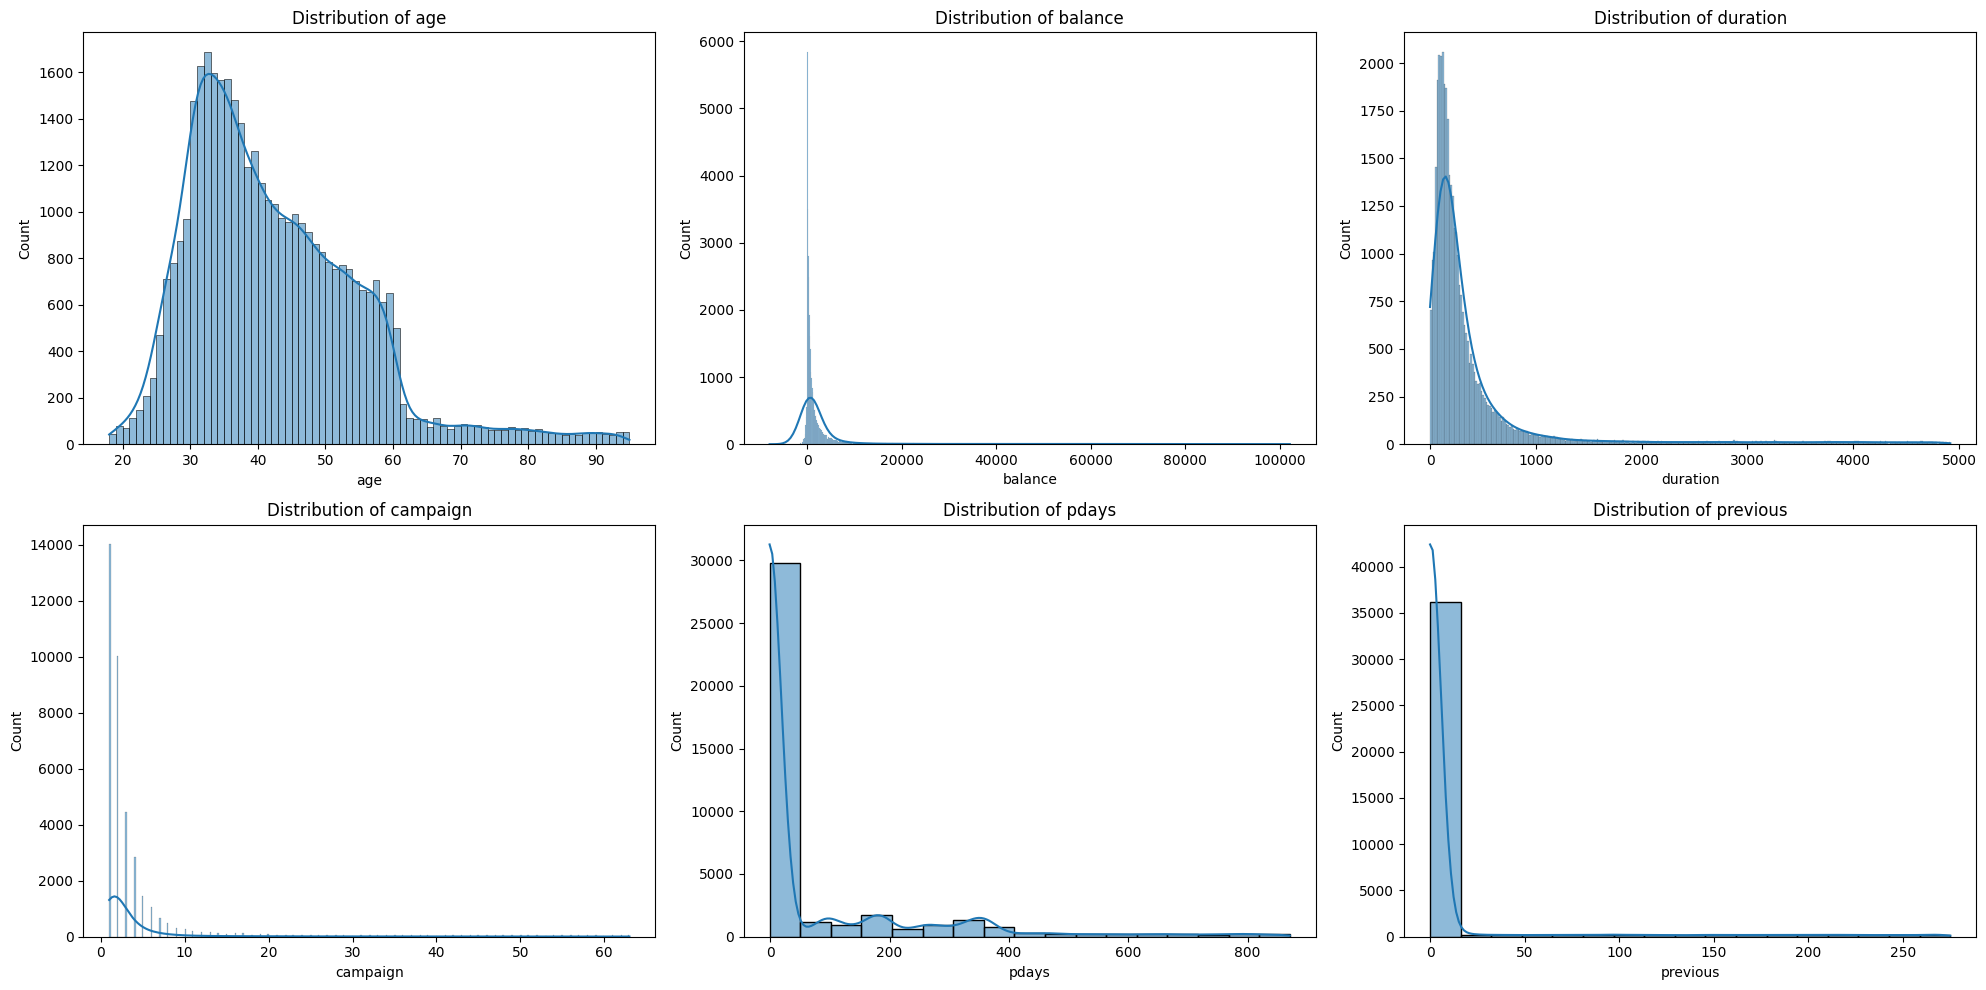

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


ncols = 3 
nrows = (len(train_eda.select_dtypes('int').columns) + ncols - 1) // ncols 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flatten()  


for i, col in enumerate(train_eda.select_dtypes('int').columns):
    sns.histplot(train_eda[col], kde=True, ax=axes[i])  
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

<div style="color:red">Features such as balance, duration, campaign, pdays, previous are <i>highly skewed</i></div>

#### Analysis of the above variables and binning ideas


<div class="alert alert-block alert-info" style="font-family:Verdana, sans-serif; color:purple;font-size:16px"> 📌 it's well-known that a tree(/forest) algorithm (xgboost/rpart/etc.) will generally 'prefer' continuous variables over binary categorical ones in its variable selection, since it can choose the continuous split-point wherever it wants to maximize the information gain </div>  

<href>More on this: https://stackoverflow.com/questions/51601122/xgboost-minimize-influence-of-continuous-linear-features-as-opposed-to-categori</href>
<p><href>https://stats.stackexchange.com/questions/171192/why-do-decision-trees-rpart-prefer-to-choose-continuous-over-categorical-variabl</href></p>

Number of entries <0, i.e negative balance is 2971
Number of entries =0, i.e negative balance is 2799

Analysis for balance:
--------------------------------------------------
Total records: 39,211
Range: -8,019.00 to 102,127.00
Mean: 5,441.78
Median: 549.00
Standard deviation: 16,365.29
Skewness: 4.06

Percentile Distribution:
0th percentile: -8,019.00
10th percentile: 0.00
25th percentile: 98.00
50th percentile: 549.00
75th percentile: 2,030.00
90th percentile: 8,121.00
100th percentile: 102,127.00

Most Common Values:
Value 0.00: 2,799 occurrences
Value 1.00: 149 occurrences
Value 2.00: 122 occurrences
Value 4.00: 115 occurrences
Value 3.00: 104 occurrences

Suggested Binning Approaches:

1. Quartile-based bins:
Bin 1: -8,019.00 to 98.00
Bin 2: 98.00 to 549.00
Bin 3: 549.00 to 2,030.00
Bin 4: 2,030.00 to 102,127.00

2. Equal-width bins:
Bin 1: -8,019.00 to -1,539.82
Bin 2: -1,539.82 to 4,939.35
Bin 3: 4,939.35 to 11,418.53
Bin 4: 11,418.53 to 17,897.71
Bin 5: 17,897.71 to 24,376.88


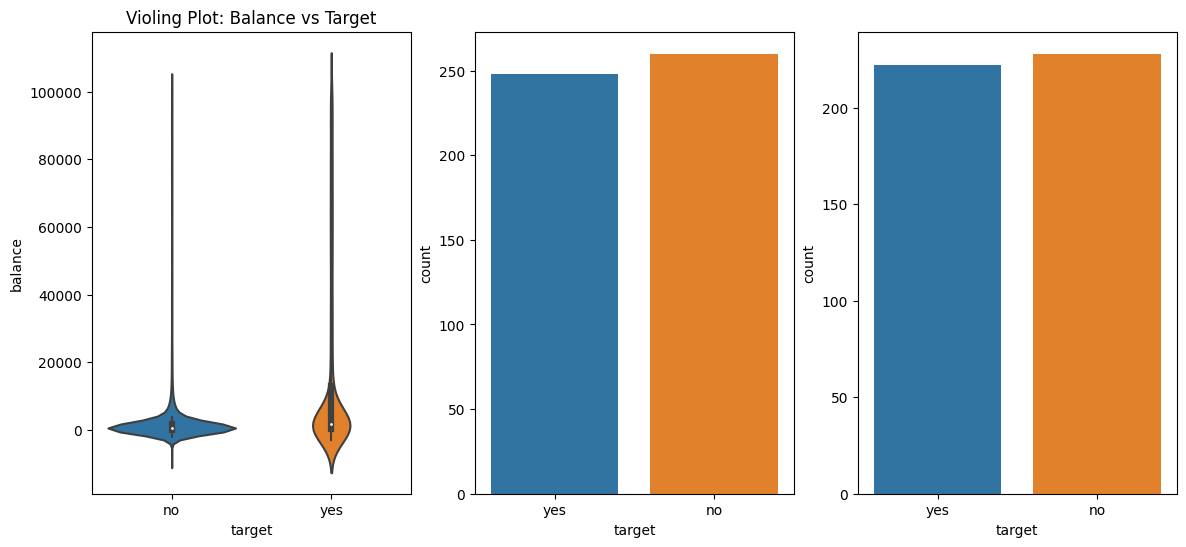

In [14]:
#Analyzing balance
fig,axes=plt.subplots(1,3,figsize=(14,6))

sns.violinplot(x='target', y='balance', data=train_eda,ax=axes[0])
axes[0].set_title('Violing Plot: Balance vs Target')

filt=train_eda[(train_eda['balance']>86641.58)]
sns.countplot(x="target",data= filt, ax=axes[1])
# axis[1].set_title()

filt2=train_eda[(train_eda['balance']>86641)&(train_eda['balance']<100000)]
sns.countplot(x="target",data= filt2, ax=axes[2])
#from 70,no begins to increase once again

print(f"Number of entries <0, i.e negative balance is {(train_eda['balance']<0).sum()}")
print(f"Number of entries =0, i.e negative balance is {(train_eda['balance']==0).sum()}")
# _, bins = pd.qcut(train_eda['balance'], q=4, labels=['low', 'medium', 'high', 'very_high'], retbins=True)
# print("Bin edges:", [f"{edge:.2f}" for edge in bins])
suggest_bins(train_eda,"balance")

Insights from balance:
<li>Need to take care of values <0!!</li>
<li>@ >29021, probability of yes beings to level and increase, until probably 70</li>
<li><b>K-Means binning approach seems to be more appropriate (if need be)</b></li>
<li>balance >29021 and <70000, p(yes) ≥ p(no)</li>


Analysis for duration:
--------------------------------------------------
Total records: 39,211
Range: 0.00 to 4,918.00
Mean: 439.06
Median: 197.00
Standard deviation: 769.10
Skewness: 3.70

Percentile Distribution:
0th percentile: 0.00
10th percentile: 61.00
25th percentile: 109.00
50th percentile: 197.00
75th percentile: 380.00
90th percentile: 864.00
100th percentile: 4,918.00

Most Common Values:
Value 124.00: 162 occurrences
Value 114.00: 149 occurrences
Value 90.00: 145 occurrences
Value 139.00: 145 occurrences
Value 89.00: 145 occurrences

Suggested Binning Approaches:

1. Quartile-based bins:
Bin 1: 0.00 to 109.00
Bin 2: 109.00 to 197.00
Bin 3: 197.00 to 380.00
Bin 4: 380.00 to 4,918.00

2. Equal-width bins:
Bin 1: 0.00 to 289.29
Bin 2: 289.29 to 578.59
Bin 3: 578.59 to 867.88
Bin 4: 867.88 to 1,157.18
Bin 5: 1,157.18 to 1,446.47
Bin 6: 1,446.47 to 1,735.76
Bin 7: 1,735.76 to 2,025.06
Bin 8: 2,025.06 to 2,314.35
Bin 9: 2,314.35 to 2,603.65
Bin 10: 2,603.65 to 2,892.94
Bin 11: 

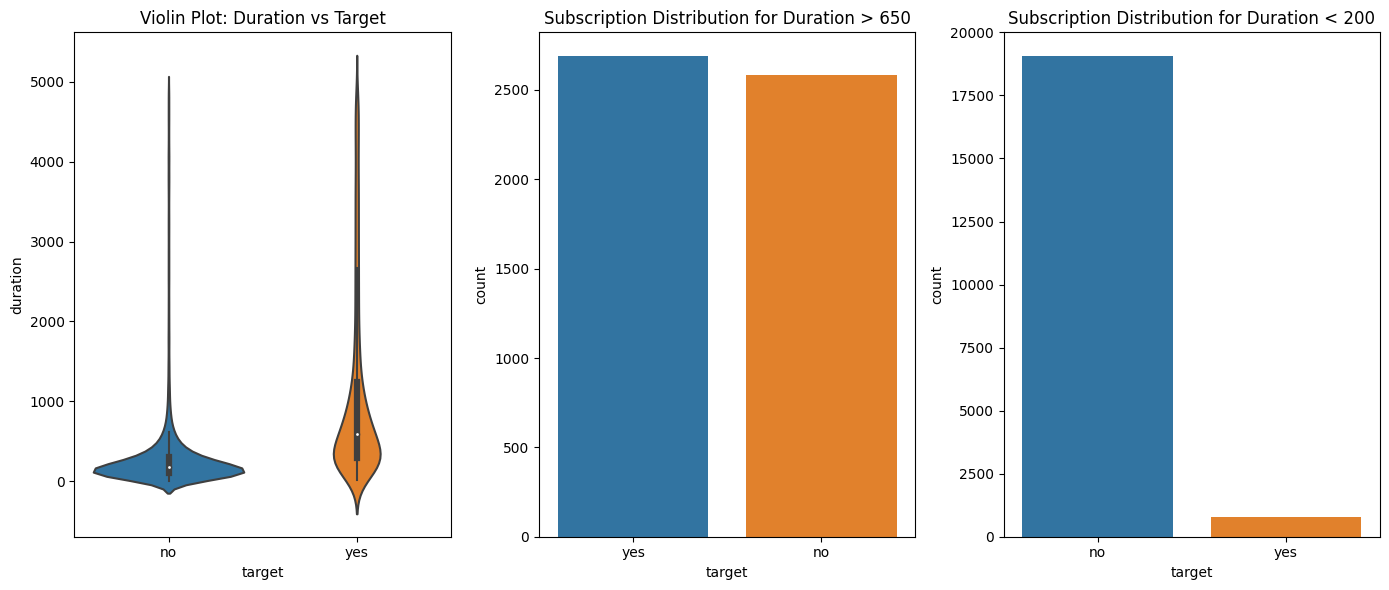

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 3, figsize=(14, 6))
sns.violinplot(x='target', y='duration', data=train_eda, ax=axes[0])
axes[0].set_title('Violin Plot: Duration vs Target')

over_65 = train_eda[(train_eda['duration'] > 650)]

sns.countplot(x='target', data=over_65, ax=axes[1])
axes[1].set_title('Subscription Distribution for Duration > 650')

less_35=train_eda[(train_eda['duration'] < 200)]
sns.countplot(x='target', data=less_35, ax=axes[2])
axes[2].set_title('Subscription Distribution for Duration < 200')

suggest_bins(train_eda,"duration")
# Show the plots
plt.tight_layout()
plt.show()

**Very Interesting observation:**
<div style="font-family:Verdana, sans-serif; color:green;"> 
<p>Our dataset is heavily imbalanced, but, when duration is over 650, the distribution of people subsribing as opposed to Not, increases!! (well almost 50 50) 😃😃 </p> 
<p>and whenever the duration is less than 200 secs, very very high probability of no subscription</p>
</div>


Analysis for campaign:
--------------------------------------------------
Total records: 39,211
Range: 1.00 to 63.00
Mean: 5.11
Median: 2.00
Standard deviation: 9.89
Skewness: 3.84

Percentile Distribution:
0th percentile: 1.00
10th percentile: 1.00
25th percentile: 1.00
50th percentile: 2.00
75th percentile: 4.00
90th percentile: 9.00
100th percentile: 63.00

Most Common Values:
Value 1.00: 14,013 occurrences
Value 2.00: 10,016 occurrences
Value 3.00: 4,470 occurrences
Value 4.00: 2,861 occurrences
Value 5.00: 1,469 occurrences

Suggested Binning Approaches:

1. Quartile-based bins:
Bin 1: 1.00 to 1.00
Bin 2: 1.00 to 2.00
Bin 3: 2.00 to 4.00
Bin 4: 4.00 to 63.00

2. Equal-width bins:
Bin 1: 1.00 to 4.65
Bin 2: 4.65 to 8.29
Bin 3: 8.29 to 11.94
Bin 4: 11.94 to 15.59
Bin 5: 15.59 to 19.24
Bin 6: 19.24 to 22.88
Bin 7: 22.88 to 26.53
Bin 8: 26.53 to 30.18
Bin 9: 30.18 to 33.82
Bin 10: 33.82 to 37.47
Bin 11: 37.47 to 41.12
Bin 12: 41.12 to 44.76
Bin 13: 44.76 to 48.41
Bin 14: 48.41 to 52.

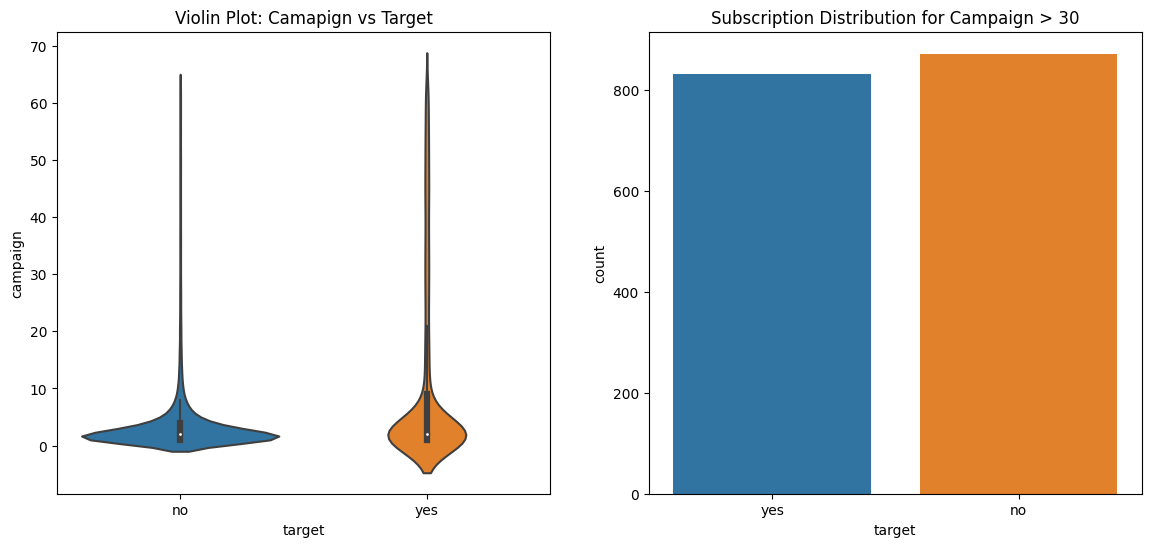

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.violinplot(x='target', y='campaign', data=train_eda, ax=axes[0])
axes[0].set_title('Violin Plot: Camapign vs Target')

over_30 = train_eda[(train_eda['campaign'] > 30)]

sns.countplot(x='target', data=over_30, ax=axes[1])
axes[1].set_title('Subscription Distribution for Campaign > 30')

suggest_bins(train_eda,"campaign")
plt.show()

**Insight**
<div style="font-family:Verdana, sans-serif; color:green;"> 
<p>and whenever the duration is >30 secs, both yes and no have similar probabilities</p>
</div>


Analysis for age:
--------------------------------------------------
Total records: 39,211
Range: 18.00 to 95.00
Mean: 42.12
Median: 40.00
Standard deviation: 12.71
Skewness: 1.12

Percentile Distribution:
0th percentile: 18.00
10th percentile: 29.00
25th percentile: 33.00
50th percentile: 40.00
75th percentile: 50.00
90th percentile: 58.00
100th percentile: 95.00

Most Common Values:
Value 32.00: 1,688 occurrences
Value 31.00: 1,629 occurrences
Value 33.00: 1,599 occurrences
Value 35.00: 1,571 occurrences
Value 34.00: 1,566 occurrences

Suggested Binning Approaches:

1. Quartile-based bins:
Bin 1: 18.00 to 33.00
Bin 2: 33.00 to 40.00
Bin 3: 40.00 to 50.00
Bin 4: 50.00 to 95.00

2. Equal-width bins:
Bin 1: 18.00 to 22.53
Bin 2: 22.53 to 27.06
Bin 3: 27.06 to 31.59
Bin 4: 31.59 to 36.12
Bin 5: 36.12 to 40.65
Bin 6: 40.65 to 45.18
Bin 7: 45.18 to 49.71
Bin 8: 49.71 to 54.24
Bin 9: 54.24 to 58.76
Bin 10: 58.76 to 63.29
Bin 11: 63.29 to 67.82
Bin 12: 67.82 to 72.35
Bin 13: 72.35 to 76.88


<Axes: xlabel='target', ylabel='count'>

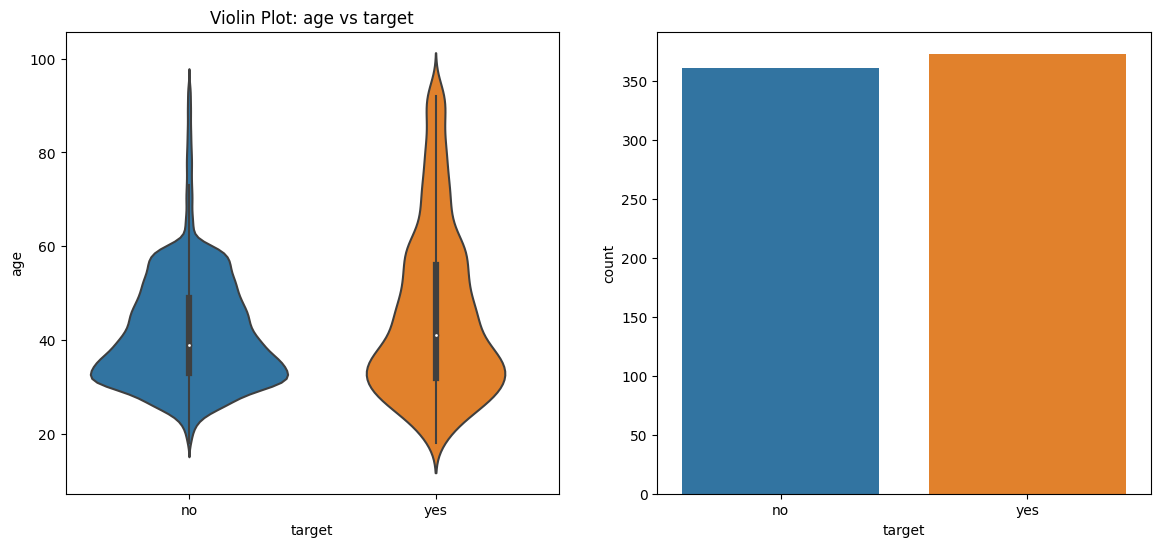

In [17]:
suggest_bins(train_eda,"age")
fig,axes=plt.subplots(1,2,figsize=(14,6))

sns.violinplot(x="target",y="age",data=train_eda,ax=axes[0])
axes[0].set_title('Violin Plot: age vs target')

filt=train_eda[train_eda['age']>79]

sns.countplot(x="target",data=filt,ax=axes[1])


**Insights age**:  
- 79 is a key figure, p(yes) starts increasing



Analysis for pdays:
--------------------------------------------------
Total records: 39,211
Range: -1.00 to 871.00
Mean: 72.26
Median: -1.00
Standard deviation: 160.94
Skewness: 2.61

Percentile Distribution:
0th percentile: -1.00
10th percentile: -1.00
25th percentile: -1.00
50th percentile: -1.00
75th percentile: -1.00
90th percentile: 312.00
100th percentile: 871.00

Most Common Values:
Value -1.00: 29,446 occurrences
Value 182.00: 135 occurrences
Value 92.00: 117 occurrences
Value 91.00: 106 occurrences
Value 183.00: 100 occurrences

Suggested Binning Approaches:

1. Quartile-based bins:
Bin 1: -1.00 to -1.00
Bin 2: -1.00 to -1.00
Bin 3: -1.00 to -1.00
Bin 4: -1.00 to 871.00

2. Equal-width bins:
Bin 1: -1.00 to 50.29
Bin 2: 50.29 to 101.59
Bin 3: 101.59 to 152.88
Bin 4: 152.88 to 204.18
Bin 5: 204.18 to 255.47
Bin 6: 255.47 to 306.76
Bin 7: 306.76 to 358.06
Bin 8: 358.06 to 409.35
Bin 9: 409.35 to 460.65
Bin 10: 460.65 to 511.94
Bin 11: 511.94 to 563.24
Bin 12: 563.24 to 614.53


<Axes: xlabel='target', ylabel='count'>

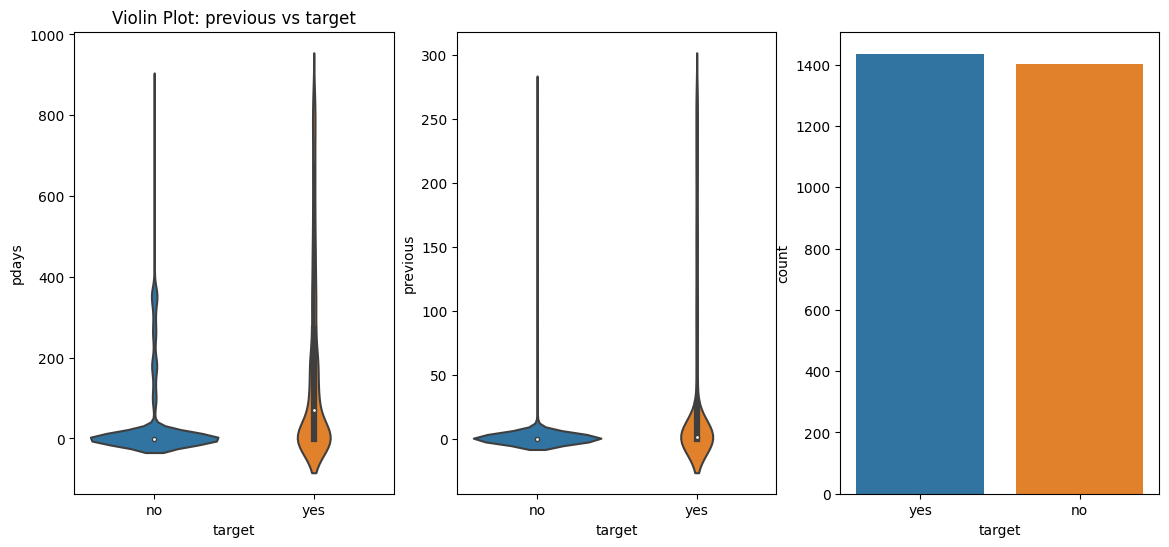

In [18]:
suggest_bins(train_eda,"pdays")
fig,axes=plt.subplots(1,3,figsize=(14,6))

sns.violinplot(x="target",y="pdays",data=train_eda,ax=axes[0])
axes[0].set_title('Violin Plot: pdays vs target')


sns.violinplot(x="target",y="previous",data=train_eda,ax=axes[1])
axes[0].set_title('Violin Plot: previous vs target')

suggest_bins(train_eda,"previous")


filt=train_eda[train_eda['previous']>32]

sns.countplot(x="target",data=filt,ax=axes[2])

- The distribution of pdays and previous is <i>extremely similar</i>
- Whenever pdays=-1 <-> previous=0
- 75 percent of values in pdays are -1 and 75 percent values is previous are 0
- 32 is when p(yes) > p(no) for previous

Some <u>very *interesting* insight</u>, whenever pdays is -1 <-> previous is 0 i.e   
<span style="font-family:Verdana, sans-serif; color:blue;"> if the candidate is not previously contacted (-1), the number of contacts performed before this campaign for this client is 0 </span>

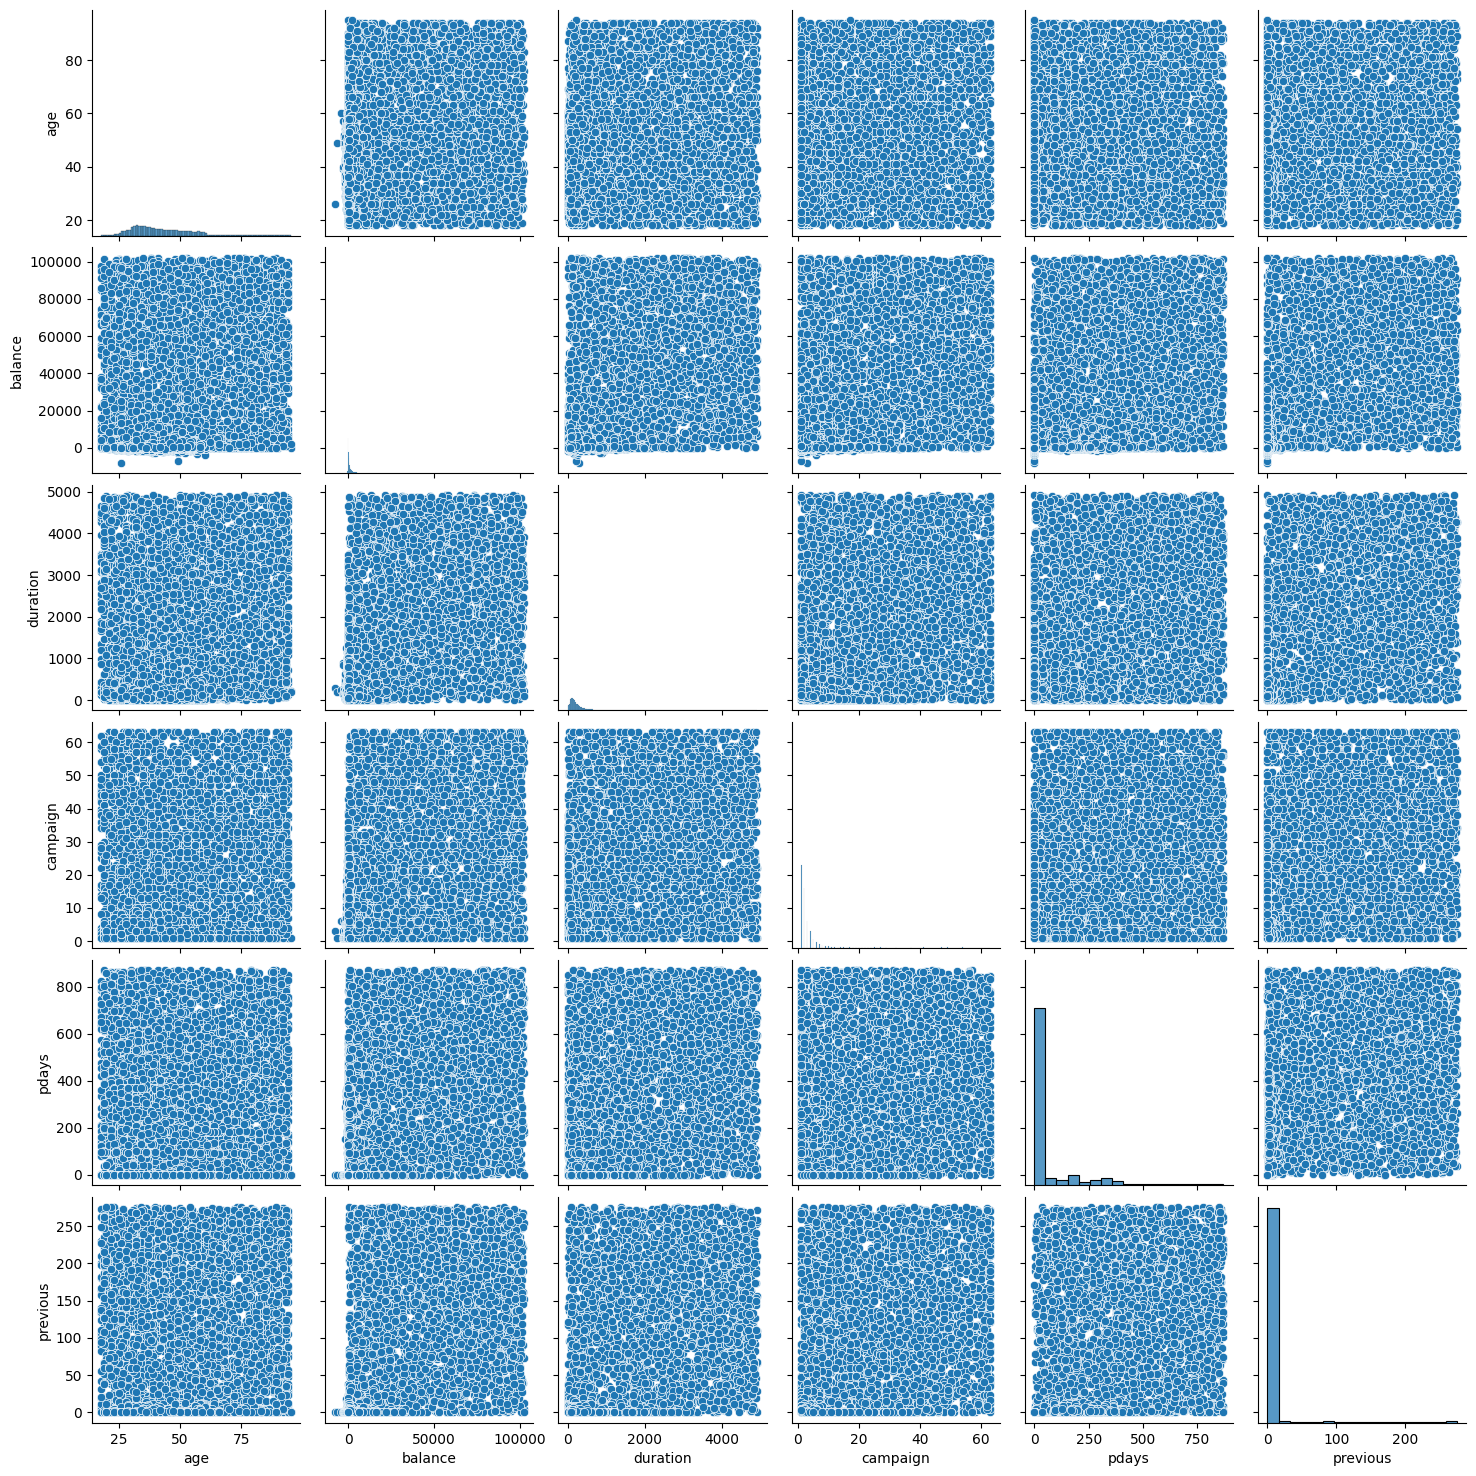

In [19]:
sns.pairplot(train_eda)

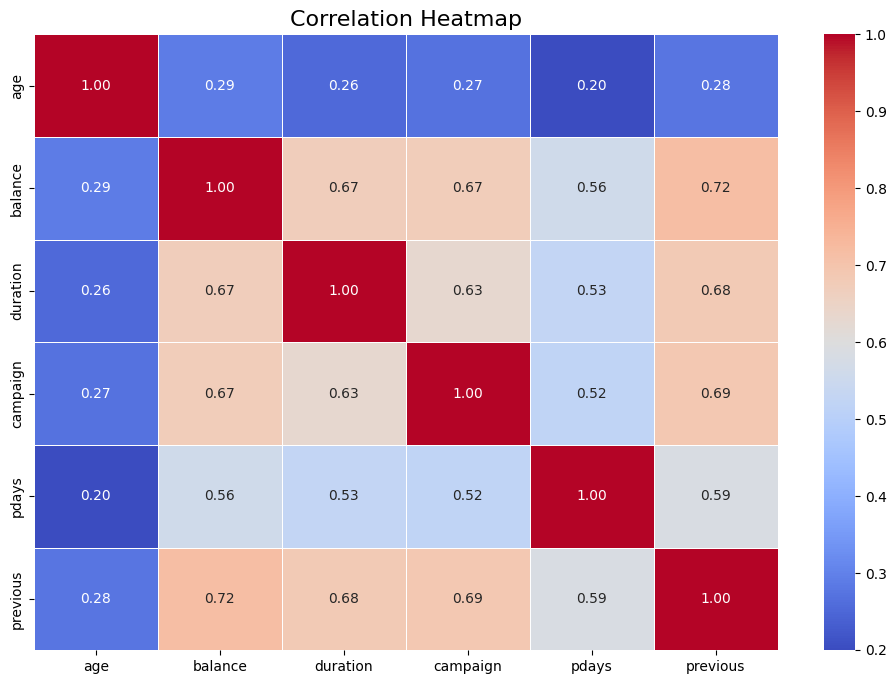

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


corr_matrix = train_eda.select_dtypes('int').corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap', fontsize=16)

plt.show()

**Insights:**
<div style="font-family:Verdana, sans-serif; color:blue;"> 
<li>balance-previous highest corr 0.72   </li>
<li> balance-duration, balance-campaign, duration-campaign, duration-previous, campaign-previous (60-70) </li>
<li> balance-pdays, duration-pdays, campaign-pdays, previous-pdays(50-60)</li>
<li> balance-campaign-duration-pdays-previous (0.50 to 0.70)</li>
</div>

We are aware that our numerical variables are highly skewed, except for maybe age..so, 

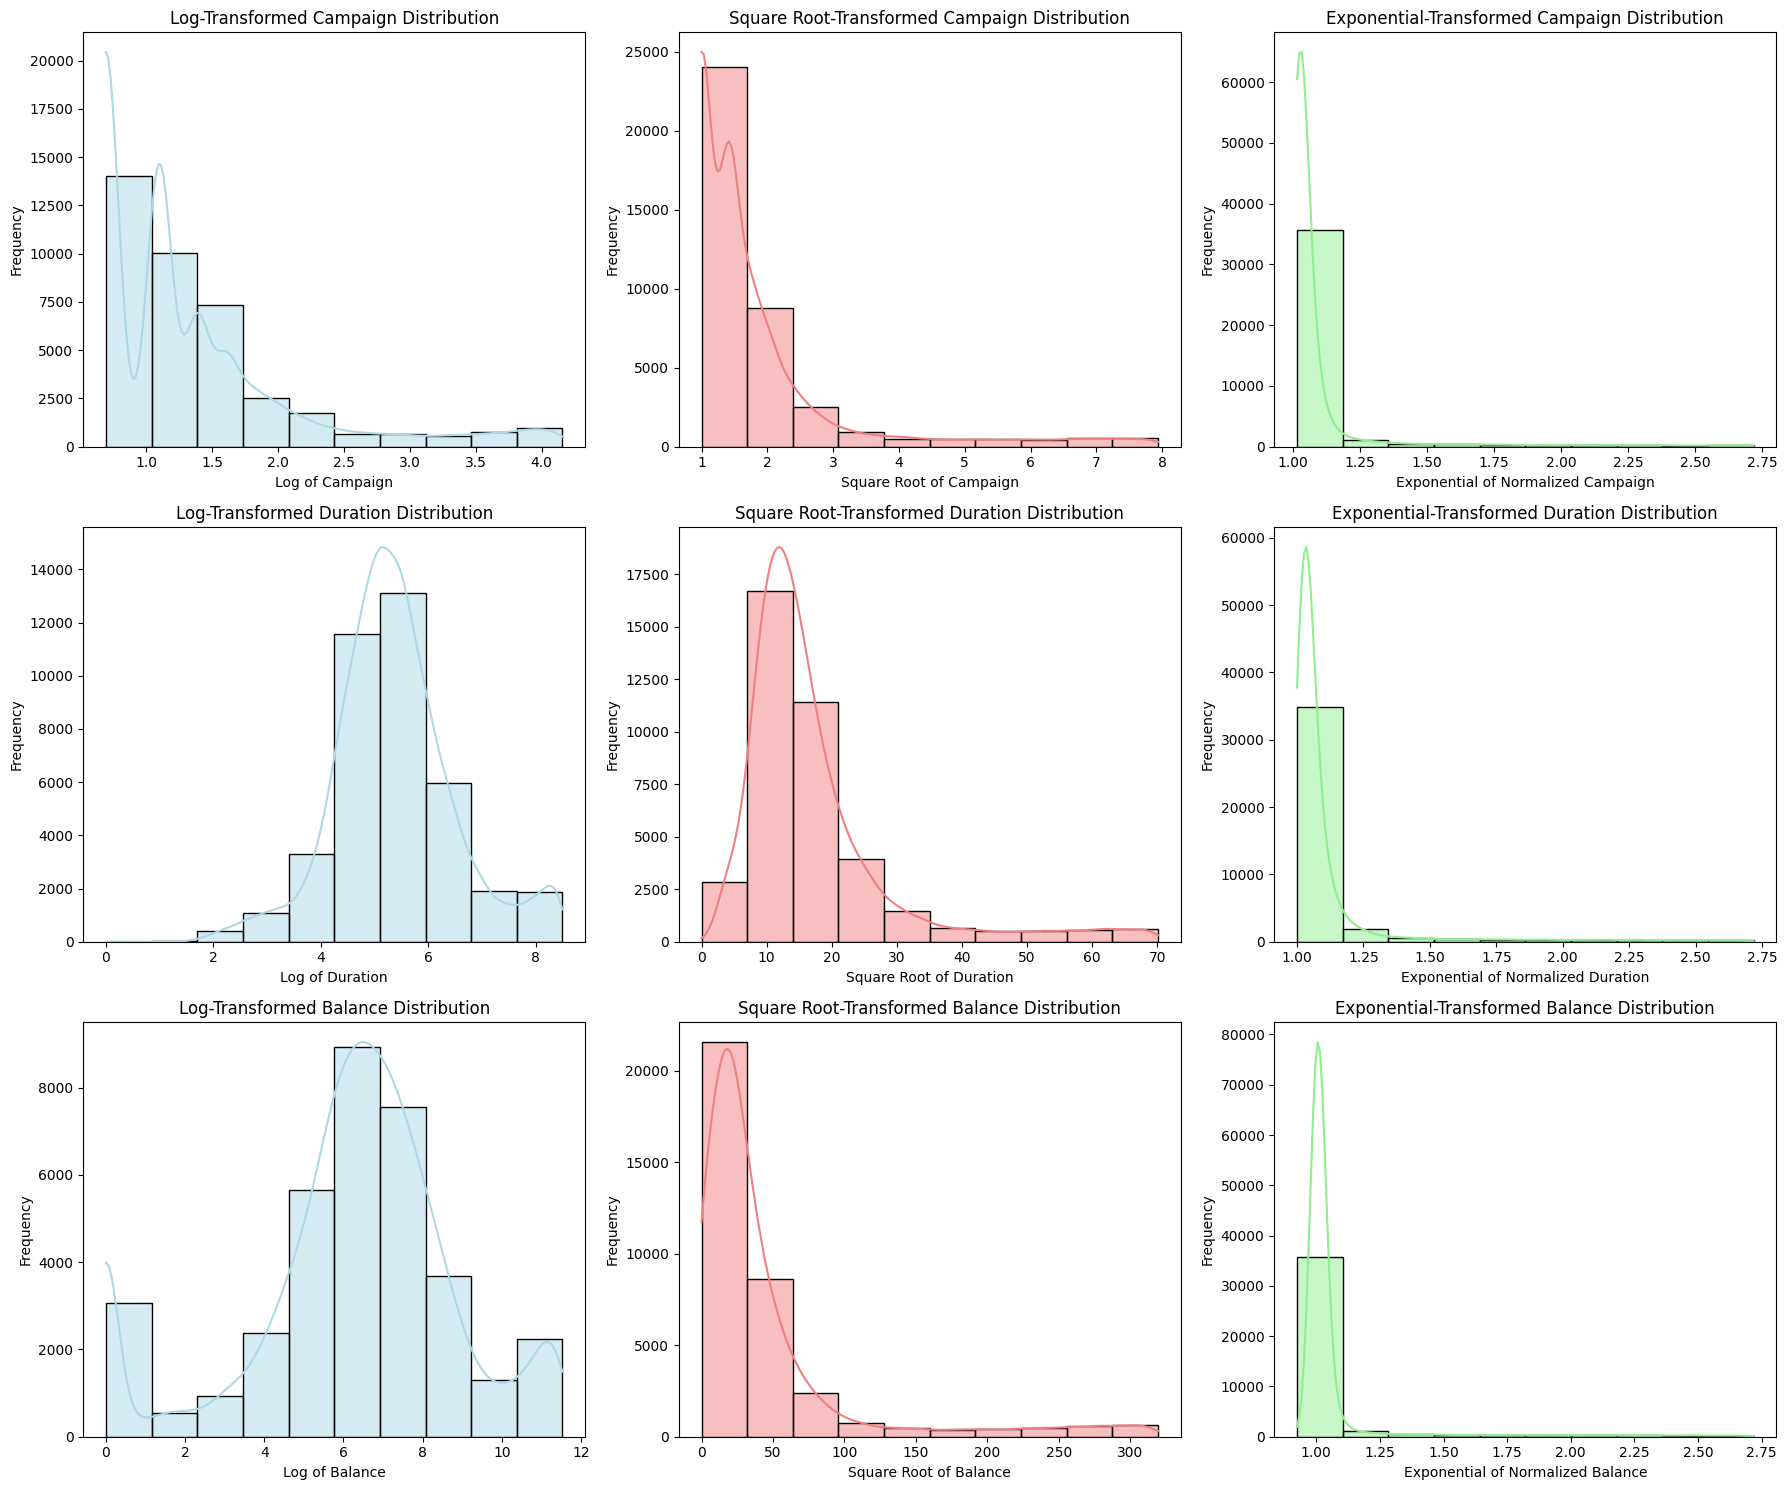

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Log transformation
train_eda['campaign_log'] = np.log1p(train_eda['campaign'])
train_eda['duration_log'] = np.log1p(train_eda['duration'])
train_eda['balance_log'] = np.log1p(train_eda['balance'])

# Square root transformation
train_eda['campaign_sqrt'] = np.sqrt(train_eda['campaign'])
train_eda['duration_sqrt'] = np.sqrt(train_eda['duration'])
train_eda['balance_sqrt'] = np.sqrt(train_eda['balance'])

# Exponential transformation

train_eda['campaign_exp'] = np.exp(train_eda['campaign'] / train_eda['campaign'].max())
train_eda['duration_exp'] = np.exp(train_eda['duration'] / train_eda['duration'].max())
train_eda['balance_exp'] = np.exp(train_eda['balance'] / train_eda['balance'].max())

# Create plots
plt.figure(figsize=(18, 15))

# Campaign plots
plt.subplot(3, 3, 1)
sns.histplot(train_eda['campaign_log'], bins=10, kde=True, color='lightblue')
plt.title("Log-Transformed Campaign Distribution")
plt.xlabel("Log of Campaign")
plt.ylabel("Frequency")

plt.subplot(3, 3, 2)
sns.histplot(train_eda['campaign_sqrt'], bins=10, kde=True, color='lightcoral')
plt.title("Square Root-Transformed Campaign Distribution")
plt.xlabel("Square Root of Campaign")
plt.ylabel("Frequency")

plt.subplot(3, 3, 3)
sns.histplot(train_eda['campaign_exp'], bins=10, kde=True, color='lightgreen')
plt.title("Exponential-Transformed Campaign Distribution")
plt.xlabel("Exponential of Normalized Campaign")
plt.ylabel("Frequency")

# Duration plots
plt.subplot(3, 3, 4)
sns.histplot(train_eda['duration_log'], bins=10, kde=True, color='lightblue')
plt.title("Log-Transformed Duration Distribution")
plt.xlabel("Log of Duration")
plt.ylabel("Frequency")

plt.subplot(3, 3, 5)
sns.histplot(train_eda['duration_sqrt'], bins=10, kde=True, color='lightcoral')
plt.title("Square Root-Transformed Duration Distribution")
plt.xlabel("Square Root of Duration")
plt.ylabel("Frequency")

plt.subplot(3, 3, 6)
sns.histplot(train_eda['duration_exp'], bins=10, kde=True, color='lightgreen')
plt.title("Exponential-Transformed Duration Distribution")
plt.xlabel("Exponential of Normalized Duration")
plt.ylabel("Frequency")

# Balance plots
plt.subplot(3, 3, 7)
sns.histplot(train_eda['balance_log'], bins=10, kde=True, color='lightblue')
plt.title("Log-Transformed Balance Distribution")
plt.xlabel("Log of Balance")
plt.ylabel("Frequency")

plt.subplot(3, 3, 8)
sns.histplot(train_eda['balance_sqrt'], bins=10, kde=True, color='lightcoral')
plt.title("Square Root-Transformed Balance Distribution")
plt.xlabel("Square Root of Balance")
plt.ylabel("Frequency")

plt.subplot(3, 3, 9)
sns.histplot(train_eda['balance_exp'], bins=10, kde=True, color='lightgreen')
plt.title("Exponential-Transformed Balance Distribution")
plt.xlabel("Exponential of Normalized Balance")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**log transformation** seems more appropriate for all the variables present above

In [22]:
train_eda['last contact date'] = pd.to_datetime(train_eda['last contact date'])
train_eda['day'] = train_eda['last contact date'].dt.day
train_eda['month'] = train_eda['last contact date'].dt.month
train_eda['year'] = train_eda['last contact date'].dt.year

suggest_bins(train_eda,'year')




Analysis for year:
--------------------------------------------------
Total records: 39,211
Range: 2,008.00 to 2,010.00
Mean: 2,009.00
Median: 2,009.00
Standard deviation: 0.82
Skewness: -0.00

Percentile Distribution:
0th percentile: 2,008.00
10th percentile: 2,008.00
25th percentile: 2,008.00
50th percentile: 2,009.00
75th percentile: 2,010.00
90th percentile: 2,010.00
100th percentile: 2,010.00

Most Common Values:
Value 2,010.00: 13,147 occurrences
Value 2,008.00: 13,116 occurrences
Value 2,009.00: 12,948 occurrences

Suggested Binning Approaches:

1. Quartile-based bins:
Bin 1: 2,008.00 to 2,008.00
Bin 2: 2,008.00 to 2,009.00
Bin 3: 2,009.00 to 2,010.00
Bin 4: 2,010.00 to 2,010.00

2. Equal-width bins:
Bin 1: 2,008.00 to 2,008.12
Bin 2: 2,008.12 to 2,008.24
Bin 3: 2,008.24 to 2,008.35
Bin 4: 2,008.35 to 2,008.47
Bin 5: 2,008.47 to 2,008.59
Bin 6: 2,008.59 to 2,008.71
Bin 7: 2,008.71 to 2,008.82
Bin 8: 2,008.82 to 2,008.94
Bin 9: 2,008.94 to 2,009.06
Bin 10: 2,009.06 to 2,009.18
B

## Data preprocessing

In [23]:


#splitting the dataset into train,val and test
from sklearn.model_selection import train_test_split

#copy of the original data to work on
df_train=train_data.copy()
df_test=test_data.copy()


train_target=df_train["target"]
df_train=df_train.drop(columns="target")
X_train,X_val,y_train,y_val=train_test_split(df_train,train_target,test_size=0.2,stratify=train_target)
X_train.shape,X_val.shape,y_train.shape,y_val.shape

le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_val=le.transform(y_val)

##Encoding the labels (yes/no ->1/0)


### Dealing with missing values and encoding poutcome

In [24]:
#impute missing values poutcome, job, contact, education

def impute_poutcome(df):
    df["poutcome"].fillna("no_previous",inplace=True)
    return df
 

pipeline = Pipeline([
   
    ('imputer', ColumnTransformer([
        ('si', SimpleImputer(strategy="most_frequent"), ["job", "contact", "education"])
    ], remainder="passthrough", verbose_feature_names_out=False).set_output(transform="pandas"))
])

X_train=impute_poutcome(X_train)
X_val=impute_poutcome(X_val)
df_test=impute_poutcome(df_test)
X_train=pipeline.fit_transform(X_train)
X_val=pipeline.transform(X_val)
df_test=pipeline.transform(df_test)

print('No missing values in the train dataset' if X_train.isna().sum().sum() == 0 else 'There are missing values in the test dataset')
print('No missing values in the test dataset' if df_test.isna().sum().sum() == 0 else 'There are missing values in the test dataset')

No missing values in the train dataset
No missing values in the test dataset


### Removing outliers

In [25]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.pipeline import FunctionTransformer

def remove_outliers_balanced(X_train, y_train, columns_to_check, threshold=3): #threshold for z score calculation
    
    y_numpy = np.array(y_train)
    
    initial_zeros = (y_numpy == 0).sum()  #number of 1s in the original df
    initial_ones = (y_numpy == 1).sum()  #number of 0s in the original df
    initial_ratio = initial_zeros / initial_ones #ratio b/w the above both, since, the aim is to remove balanced
    
    zeros_mask = (y_numpy == 0)
    ones_mask = (y_numpy == 1)
    
    keep_mask = np.ones(len(y_numpy), dtype=bool)
    
    for column in columns_to_check:
        column_values = X_train[column].values.astype(float)
        
        zeros_values = column_values[zeros_mask]
        ones_values = column_values[ones_mask]
        
        # Remove NaN values for z-score calculation
        zeros_values = zeros_values[~np.isnan(zeros_values)]
        ones_values = ones_values[~np.isnan(ones_values)]
        
        if len(zeros_values) > 0:
            # Calculate z-scores for zeros class
            mean_zeros = np.mean(zeros_values)
            std_zeros = np.std(zeros_values)
            if std_zeros != 0:
                z_scores_zeros = np.abs((column_values[zeros_mask] - mean_zeros) / std_zeros)
                temp_zeros_outliers = np.zeros(len(y_numpy), dtype=bool)
                temp_zeros_outliers[zeros_mask] = (z_scores_zeros > threshold)
                keep_mask = keep_mask & ~temp_zeros_outliers
        
        if len(ones_values) > 0:
            # Calculate z-scores for ones class
            mean_ones = np.mean(ones_values)
            std_ones = np.std(ones_values)
            if std_ones != 0:
                z_scores_ones = np.abs((column_values[ones_mask] - mean_ones) / std_ones)
                temp_ones_outliers = np.zeros(len(y_numpy), dtype=bool)
                temp_ones_outliers[ones_mask] = (z_scores_ones > threshold)
                keep_mask = keep_mask & ~temp_ones_outliers
    
    # Count outliers for each class
    zeros_outliers = (~keep_mask & zeros_mask).sum()
    ones_outliers = (~keep_mask & ones_mask).sum()
    total_outliers = zeros_outliers + ones_outliers
    
    if total_outliers > 0:
        # Calculate target numbers for 90-10 split
        target_zeros_remove = int(0.8 * total_outliers)
        target_ones_remove = total_outliers - target_zeros_remove
        
        # Adjust outlier removal if needed
        if zeros_outliers > target_zeros_remove:
            # Randomly select which outliers to keep
            outlier_indices = np.where(~keep_mask & zeros_mask)[0]
            keep_indices = np.random.choice(outlier_indices, 
                                          size=zeros_outliers - target_zeros_remove,
                                          replace=False)
            keep_mask[keep_indices] = True
        
        if ones_outliers > target_ones_remove:
            outlier_indices = np.where(~keep_mask & ones_mask)[0]
            keep_indices = np.random.choice(outlier_indices,
                                          size=ones_outliers - target_ones_remove,
                                          replace=False)
            keep_mask[keep_indices] = True
    
    # Apply the mask to get clean data
    X_train_clean = X_train.iloc[keep_mask].copy()
    y_train_clean = y_numpy[keep_mask]
    
    # Calculate final ratios
    final_zeros = (y_train_clean == 0).sum()
    final_ones = (y_train_clean == 1).sum()
    final_ratio = final_zeros / final_ones
    
    print(f"Initial class ratio (0:1): {initial_ratio:.2f}")
    print(f"Final class ratio (0:1): {final_ratio:.2f}")
    print(f"Removed {(~keep_mask & zeros_mask).sum()} samples from class 0")
    print(f"Removed {(~keep_mask & ones_mask).sum()} samples from class 1")
    
    return X_train_clean, y_train_clean
    #"campaign",
columns_to_check=["balance","duration","campaign"]


X_train,y_train=remove_outliers_balanced(X_train,y_train,columns_to_check)

Initial class ratio (0:1): 5.73
Final class ratio (0:1): 5.71
Removed 1132 samples from class 0
Removed 183 samples from class 1


In [26]:
#numerical
# def encode_date(df):
#     df['last contact date'] = pd.to_datetime(df['last contact date'])
#     df['day'] = df['last contact date'].dt.day
#     df['month'] = df['last contact date'].dt.month
#     df['year'] = df['last contact date'].dt.year
#     df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
#     df['day_cos'] = np.cos(2 * np.pi * df['day']/31)
#     df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
#     df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
#     df.drop(columns=['last contact date','month','day'],inplace=True)
#     return df
def encode_date(df):
    df['last contact date'] = pd.to_datetime(df['last contact date'])
    df['day'] = df['last contact date'].dt.day
    df['month'] = df['last contact date'].dt.month
    df['year'] = df['last contact date'].dt.year
    return df.drop(columns=['last contact date'])

def transform_balance_and_duration(df):
    df['balance'] = df['balance'].apply(lambda x: max(0, x)) #balance has negative values
    df['balance'] = np.log1p(df['balance'])
    df['duration'] = np.log1p(df['duration'])
    df['campaign']=np.log1p(df['campaign'])
    return df
def pdpr(df):
    df["prepr"]=df["previous"]*df["pdays"]
    return df

def is_first_contact(df, pdays_col='pdays'):
    """
    Adds a binary column 'is_first_contact' to indicate if it's the first contact (True when pdays == -1).

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    pdays_col (str): The name of the column representing 'pdays'.

    Returns:
    pd.DataFrame: The modified DataFrame with the 'is_first_contact' column added.
    """
    df['is_first_contact'] = df[pdays_col] == -1
    return df

def bin_age_kmeans(df, age_col='age', bins=None):
    """
    Bins the age column into specified ranges using K-means-derived intervals.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    age_col (str): The name of the column representing age.
    bins (list): The edges of the bins. Example: [18.00, 30.96, 42.05, 54.91, 79.51, 95.00].
    bin_col_name (str): The name of the new column to store the binned data.

    Returns:
    pd.DataFrame: The modified DataFrame with the new binned column added.
    """
    if bins is None:
        bins = [18.00, 30.96, 42.05, 54.91, 79.51, 95.00]
    
    # Create bin labels
    bin_labels = [f'{i+1}' for i in range(len(bins) - 1)]
    
    # Bin the ages
    df[age_col] = pd.cut(df[age_col], bins=bins, labels=bin_labels, include_lowest=True)
    
    return df

def bin_balance_kmeans(df, balance_col='balance', bins=None, bin_col_name='balance_bin'):
    """
    Bins the balance column into specified ranges using K-means-derived intervals.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    balance_col (str): The name of the column representing the balance.
    bins (list): The edges of the bins. Example: [-8019.00, 1200.38, 24255.18, 56011.15, 86641.58, 102127.00].
    bin_col_name (str): The name of the new column to store the binned data.

    Returns:
    pd.DataFrame: The modified DataFrame with the new binned column added.
    """
    if bins is None:
        bins = [-8019.00, 1200.38, 24255.18, 56011.15, 86641.58, 102127.00]
    
    # Create bin labels
    bin_labels = [f' {i+1}' for i in range(len(bins) - 1)]
    
    # Bin the balances
    df[bin_col_name] = pd.cut(df[balance_col], bins=bins, labels=bin_labels, include_lowest=True)
    
    return df

import pandas as pd

def bin_previous_column(df):
    """
    Bins the 'previous' column of a DataFrame into specified ranges using predefined bin edges.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with an additional column for the binned values (as integers).
    """
    bin_edges = [0.00, 0.82, 82.99, 162.46, 238.65, 275.00]
    bin_labels = [i+1 for i in range(len(bin_edges) - 1)]  #

    
    df['previous_binned'] = pd.cut(
        df['previous'], 
        bins=bin_edges, 
        labels=bin_labels, 
        include_lowest=True
    ).astype(int)  # Ensure the binned column is of integer type
    df["previous_binned"]=df["previous_binned"]*df["pdays"]
    return df
    
    return df
pipeline = Pipeline([
    #('poutcome_replace', FunctionTransformer(replace_poutcome)),
    ('date_encoding', FunctionTransformer(encode_date)),
    ('age',FunctionTransformer(bin_age_kmeans)),
    ('pdays',FunctionTransformer(is_first_contact)),
    ('prev',FunctionTransformer(bin_previous_column)),
    ('lo',FunctionTransformer(bin_balance_kmeans)),
    #('prpr',FunctionTransformer(pdpr)),
    ('balance_duration_transform', FunctionTransformer(transform_balance_and_duration)),
])

X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
df_test = pipeline.transform(df_test)

In [27]:
X_train.drop(columns=["previous"],inplace=True)
X_val.drop(columns=["previous"],inplace=True)
df_test.drop(columns=["previous"],inplace=True)

In [28]:
#convert boolean variables to binary
def convert_booleans_to_binary(X_train, X_val, df_test):

    for df in [X_train, X_val, df_test]:
        bool_cols = df.select_dtypes(include='bool').columns
        df[bool_cols] = df[bool_cols].astype(int)
    
    return X_train, X_val, df_test

# Apply to encoded data

X_train, X_val, df_test = convert_booleans_to_binary(X_train, X_val, df_test)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30053 entries, 37670 to 7976
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   job               30053 non-null  object  
 1   contact           30053 non-null  object  
 2   education         30053 non-null  object  
 3   age               30053 non-null  category
 4   marital           30053 non-null  object  
 5   default           30053 non-null  object  
 6   balance           30053 non-null  float64 
 7   housing           30053 non-null  object  
 8   loan              30053 non-null  object  
 9   duration          30053 non-null  float64 
 10  campaign          30053 non-null  float64 
 11  pdays             30053 non-null  int64   
 12  poutcome          30053 non-null  object  
 13  day               30053 non-null  int32   
 14  month             30053 non-null  int32   
 15  year              30053 non-null  int32   
 16  is_first_contact  30053 

In [29]:
#Encoding categorical 


import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Define a custom transformer for target encoding
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, feature, target):
        self.feature = feature
        self.target = target
        self.encoding_map = {}
    
    def fit(self, X, y):
        # Calculate mean of the target for each category
        self.encoding_map = X.groupby(self.feature).apply(lambda x: y[X.index.isin(x.index)].mean())
        return self
    
    def transform(self, X):
        # Map the encoding to the feature
        X_transformed = X[self.feature].map(self.encoding_map)
        return X_transformed.values.reshape(-1, 1)  # Reshape for compatibility

categorical_features_ohe = [ "contact"] #"
categorical_features_ord=["housing","loan","poutcome","default","marital","contact","job"]
ordinal_features = ["education"] 
target_features = ["job", "poutcome"]

job_target_encoder = TargetEncoder(feature='job', target=y_train)
marital_target_encoder=TargetEncoder(feature='marital', target=y_train)

cat_ct = ColumnTransformer(
    transformers=[
        #("ohe", OneHotEncoder(), categorical_features_ohe),
        ("labelencoder",OrdinalEncoder(),categorical_features_ord),
        ("ord", OrdinalEncoder(), ordinal_features),
        #("job_te", job_target_encoder, ["job"]),
        #("marital",marital_target_encoder,["marital"]),
        #("poutcome_te", poutcome_target_encoder, ["poutcome"]),
        # ("contact_te",contact_target_encoder,["contact"]),
        # ("default_target_encoder",default_target_encoder,["default"]),
        # ("housing_target_encoder",housing_target_encoder,["housing"]),
        # ("loan_target_encoder",loan_target_encoder,["loan"])
    ],
    remainder="passthrough"
)


cat_ct.fit(X_train, y_train)
X_train_transformed = cat_ct.transform(X_train)
X_val_transformed = cat_ct.transform(X_val)
df_test_transformed = cat_ct.transform(df_test)

## Resampling

In [30]:
import numpy as np
import pandas as pd
from sklearn.utils import resample


df_train = pd.DataFrame(X_train_transformed)  
df_train['target'] = y_train     


majority_class = df_train[df_train['target'] == 0]
minority_class = df_train[df_train['target'] == 1]


minority_upsampled = resample(minority_class,
                              replace=True,     
                              n_samples=len(majority_class),  
                              random_state=42) 


upsampled = pd.concat([majority_class, minority_upsampled], ignore_index=True)


X_train_upsampled = upsampled.drop('target', axis=1).values  
y_train_upsampled = upsampled['target'].values 

In [31]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from collections import Counter

# First let's try SMOTEENN
smote_enn = SMOTEENN(random_state=42,sampling_strategy=0.5)
X_train_upsampled, y_train_upsampled = smote_enn.fit_resample(X_train_transformed, y_train)

## Training and Validating

In [32]:

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, 
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_probs):
    # Calculate the ROC curve points and AUC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(y_true, y_probs):

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}', color='purple')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

Fitting 2 folds for each of 24 candidates, totalling 48 fits
Best Logistic Regression F1 Score: 0.7365738254688352


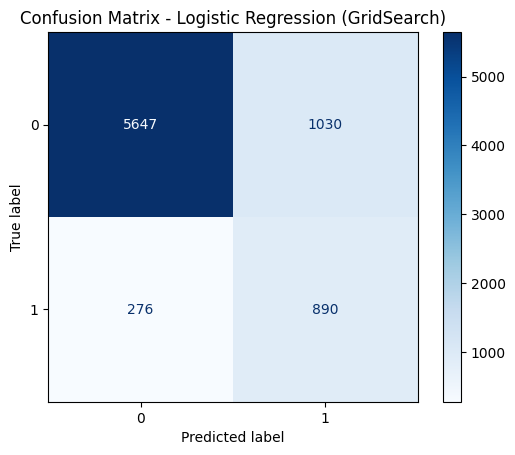

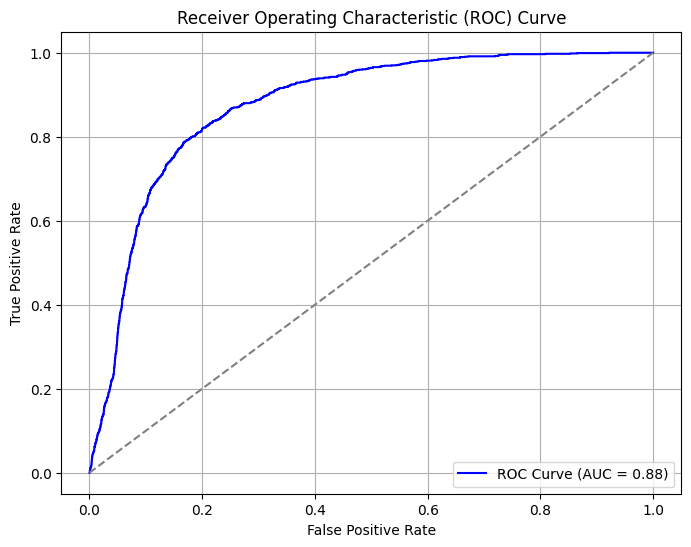

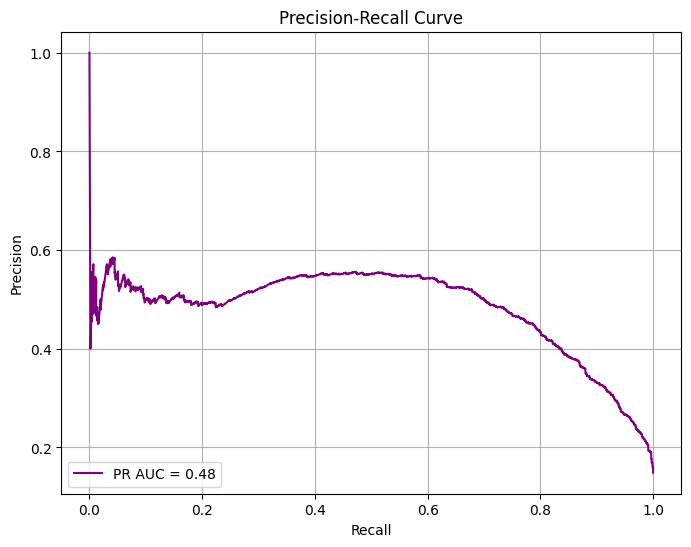

Best parameters found by GridSearchCV: {'logisticregression__C': 10, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

param_grid_log_reg = {
    'logisticregression__penalty': ['l2','l1'], 
    'logisticregression__C': [0.1, 1, 10], 
    'logisticregression__solver': ['lbfgs', 'liblinear','saga','newton-cg']  
}

log_reg = LogisticRegression(random_state=42,max_iter=2000,)
pipeline = make_pipeline(StandardScaler(), log_reg)
grid_search_log_reg = GridSearchCV(estimator=pipeline, param_grid=param_grid_log_reg, 
                                   scoring='f1_macro', cv=2, verbose=1, n_jobs=-1)

grid_search_log_reg.fit(X_train_upsampled, y_train_upsampled)

best_log_reg_model = grid_search_log_reg.best_estimator_

y_pred_log_reg = best_log_reg_model.predict(X_val_transformed)
y_pred_log_probs=best_log_reg_model.predict_proba(X_val_transformed)
f1_log_reg = f1_score(y_val, y_pred_log_reg, average='macro')
print(f"Best Logistic Regression F1 Score: {f1_log_reg}")

cm_log_reg = confusion_matrix(y_val, y_pred_log_reg)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg)
disp_log_reg.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.show()


plot_roc_curve(y_val,y_pred_log_probs[:,1])
plot_pr_curve(y_val,y_pred_log_probs[:,1])

print("Best parameters found by GridSearchCV:", grid_search_log_reg.best_params_)

**Insights from Logistic Regression Model**
<div style="font-family:Verdana, sans-serif; color:blue;"> 
<p>F1 Score: The logistic regression model achieved a reasonable F1 score of 0.716, balancing precision and recall, though there is room for improvement.</p>
<p>Best Hyperparameters: Optimal hyperparameters identified by GridSearchCV: **C=10, penalty=‘l2’, and solver=‘liblinear’**, indicating a well-regularized model.</p>
 <p>Confusion Matrix: With 5337 True Negatives and 970 True Positives, the model performs better at predicting negatives, but false positives (1340) show room for improvement in handling class imbalance. </p>
</div>

In [36]:
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt


# svm_model = SVC(C=1, kernel='rbf', gamma='scale', random_state=42,probability=True)

# svm_pipeline = make_pipeline(StandardScaler(), svm_model)

# svm_pipeline.fit(X_train_upsampled, y_train_upsampled)

# y_pred_svm = svm_pipeline.predict(X_val_transformed)
# y_pred_svm_probs = svm_pipeline.predict_proba(X_val_transformed)


# f1_svm = f1_score(y_val, y_pred_svm, average='macro')
# print(f"Best SVM F1 Score (Validation): {f1_svm}")

# y_train_pred_svm = svm_pipeline.predict(X_train_upsampled)
# f1_train_svm = f1_score(y_train_upsampled, y_train_pred_svm, average='macro')
# print(f"Training F1 Score: {f1_train_svm}")

# # Confusion Matrix
# cm_svm = confusion_matrix(y_val, y_pred_svm)
# disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
# disp_svm.plot(cmap='Blues')
# plt.title("Confusion Matrix - SVM")
# plt.show()

# # ROC Curve
# plot_roc_curve(y_val, y_pred_svm_probs[:, 1])

# # PR Curve
# plot_pr_curve(y_val, y_pred_svm_probs[:, 1])

Fitting 5 folds for each of 192 candidates, totalling 960 fits

Decision Tree Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 15, 'min_samples_split': 0.1}

Decision Tree Train F1 Score: 0.8876317334627047
Decision Tree Validation F1 Score: 0.7305265269386226

Decision Tree Confusion Matrix:
[[5634 1043]
 [ 292  874]]


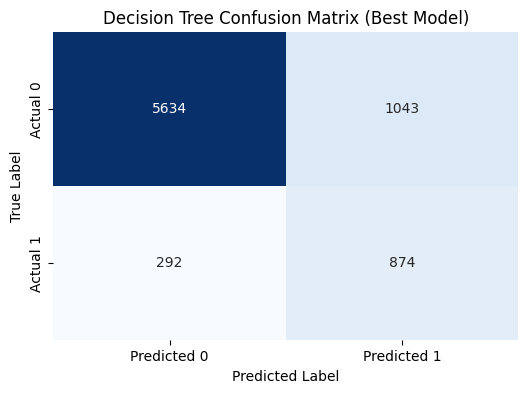

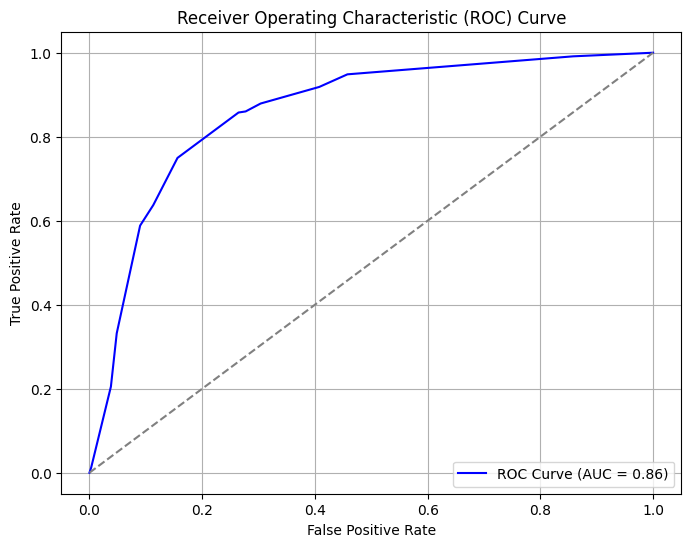

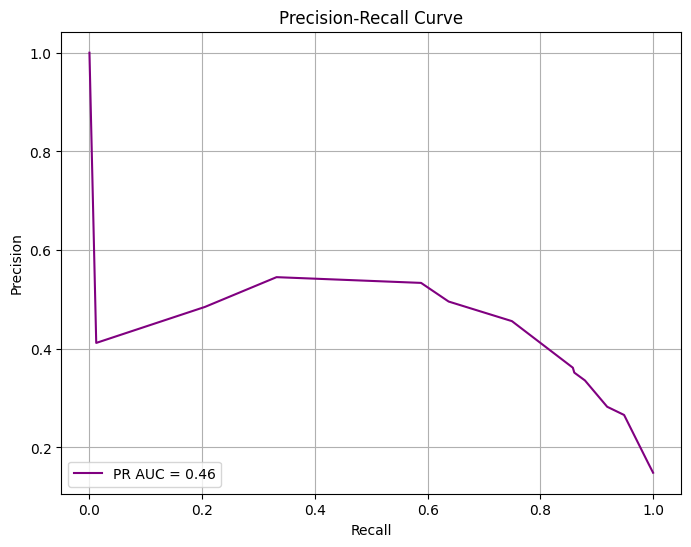

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, 10], 
    'max_leaf_nodes': [5, 10, 15, 20], 
    'min_samples_split': [0.1, 0.2, 0.3],
    'class_weight': ['balanced', None]
}

decision_tree = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=decision_tree,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=5, 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_upsampled, y_train_upsampled)

best_dt_model = grid_search.best_estimator_

y_val_dt = best_dt_model.predict(X_val_transformed)

# Evaluation metrics
dt_train_f1 = f1_score(y_train_upsampled, best_dt_model.predict(X_train_upsampled), average='macro')
dt_val_f1 = f1_score(y_val, y_val_dt, average='macro')
dt_confusion = confusion_matrix(y_val, y_val_dt)

print("\nDecision Tree Best Parameters:", grid_search.best_params_)
print("\nDecision Tree Train F1 Score:", dt_train_f1)
print("Decision Tree Validation F1 Score:", dt_val_f1)
print("\nDecision Tree Confusion Matrix:")
print(dt_confusion)

# Plot confusion matrix
y_val_dt_probs=best_dt_model.predict_proba(X_val_transformed)
plot_confusion_matrix(dt_confusion, title='Decision Tree Confusion Matrix (Best Model)')
plot_roc_curve(y_val,y_val_dt_probs[:,1])
plot_pr_curve(y_val,y_val_dt_probs[:,1])


Random Forest Cross-Validation
Random Forest Cross-Validation F1 Scores: [0.90834723 0.94916676 0.980868   0.97796604 0.97773803]
Random Forest Average CV F1 Score: 0.9588172106817382

Random Forest Confusion Matrix:
[[5956  721]
 [ 355  811]]
Random Forest Train F1 Score: 1.0
Random Forest Validation F1 Score: 0.7591701800122049


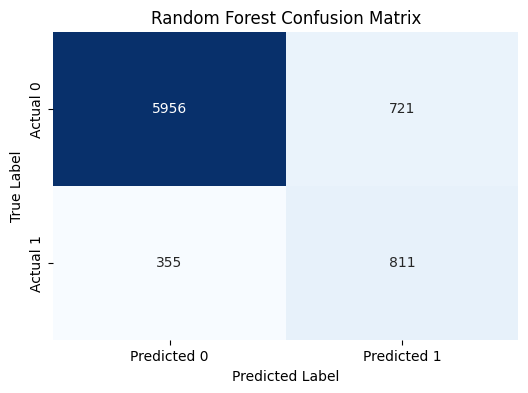

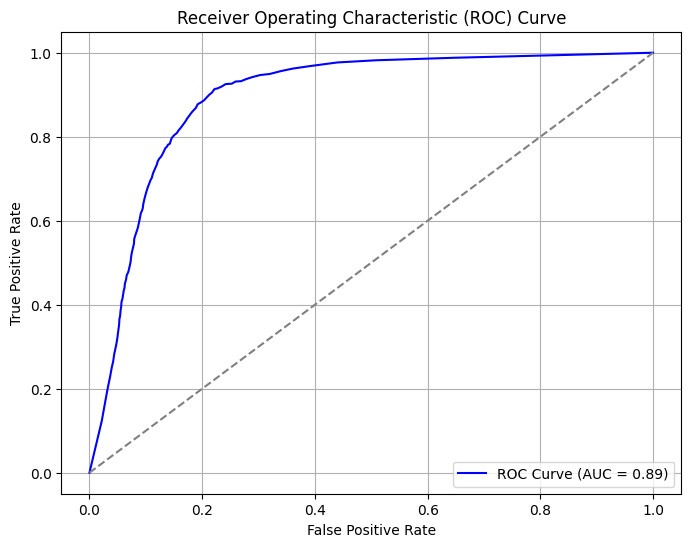

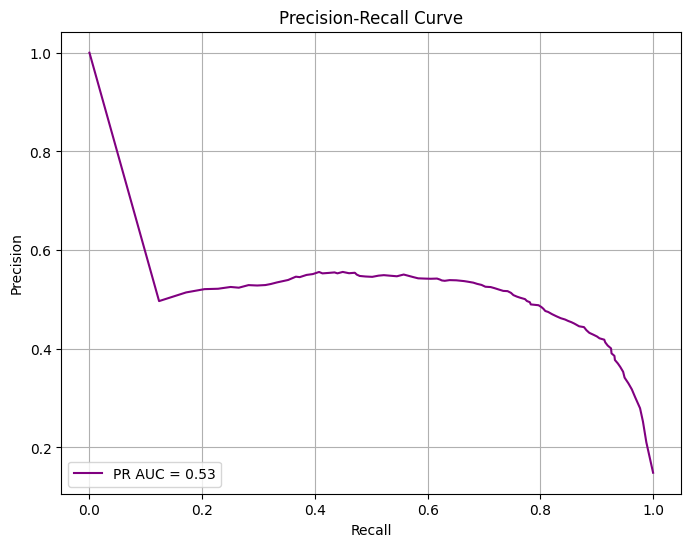

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Random Forest Cross-Validation
print("Random Forest Cross-Validation")
rf_cv_scores = cross_val_score(rf_model, X_train_upsampled, y_train_upsampled, scoring='f1_macro', cv=5)
print("Random Forest Cross-Validation F1 Scores:", rf_cv_scores)
print("Random Forest Average CV F1 Score:", np.mean(rf_cv_scores))


rf_model.fit(X_train_upsampled, y_train_upsampled)

y_val_pred_rf = rf_model.predict(X_val_transformed)
y_val_rf_probs=rf_model.predict_proba(X_val_transformed)


rf_confusion = confusion_matrix(y_val, y_val_pred_rf)
print("\nRandom Forest Confusion Matrix:")
print(rf_confusion)
print("Random Forest Train F1 Score:", f1_score(y_train_upsampled, rf_model.predict(X_train_upsampled), average='macro'))
print("Random Forest Validation F1 Score:", f1_score(y_val, y_val_pred_rf, average='macro'))


plot_confusion_matrix(rf_confusion, title='Random Forest Confusion Matrix')
plot_roc_curve(y_val,y_val_rf_probs[:,1])
plot_pr_curve(y_val,y_val_rf_probs[:,1])

- **Random Forest model shows strong performance**, with an average cross-validation F1 score of 0.9676, indicating good generalization across multiple folds.
- **Confusion matrix shows high accuracy**, with a relatively low number of false positives (616) and false negatives (406), suggesting good classification of both classes.
- **Training F1 score of 1.0** indicates that the model perfectly fits the training data, potentially suggesting overfitting
- **High F1 score consistency** across the cross-validation folds shows that the model is not sensitive to different subsets of the data and can generalize well.
- **Random Forest's performance** is likely attributed to its ability to model complex relationships through ensemble learning and decision trees, reducing variance and avoiding overfitting.


XGBoost Cross-Validation
XGBoost Cross-Validation F1 Scores: [0.89152128 0.95161695 0.98415304 0.98162116 0.98087251]
XGBoost Average CV F1 Score: 0.957956986997399

XGBoost Confusion Matrix:
[[5947  730]
 [ 311  855]]
XGBoost Train F1 Score: 0.9907525541854074
XGBoost Validation F1 Score: 0.770556414317203


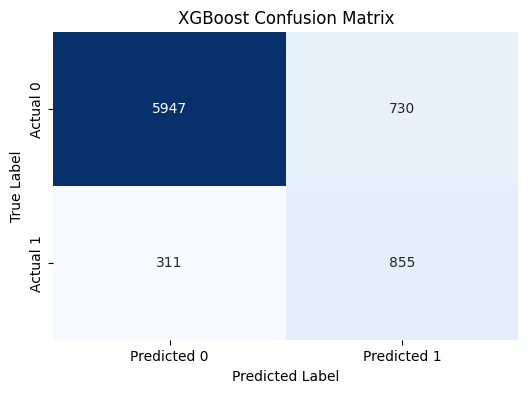

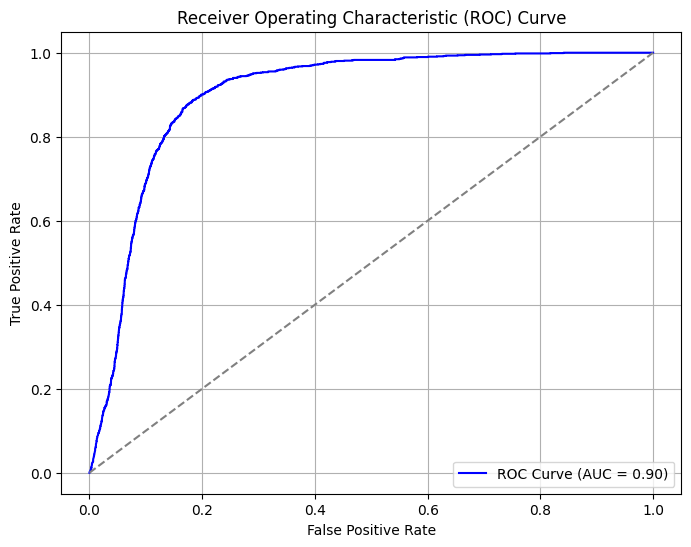

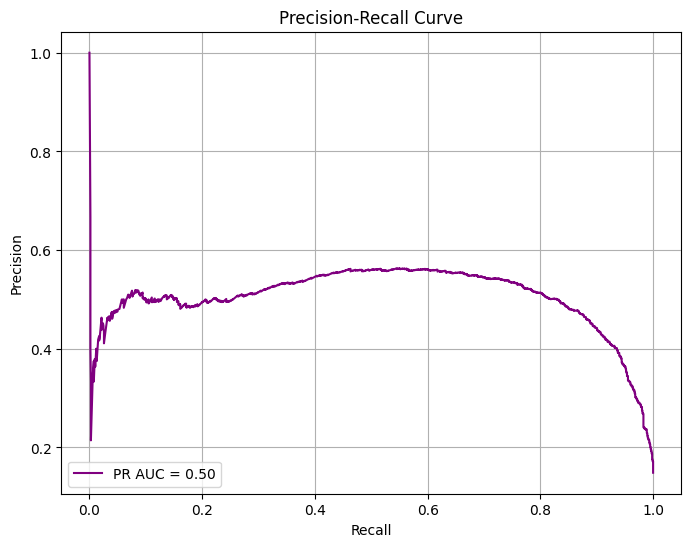

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score


def f1_eval(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    return 'f1', f1


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


print("\nXGBoost Cross-Validation")
xgb_cv_scores = cross_val_score(xgb_model, X_train_upsampled, y_train_upsampled, scoring='f1_macro', cv=5)
print("XGBoost Cross-Validation F1 Scores:", xgb_cv_scores)
print("XGBoost Average CV F1 Score:", np.mean(xgb_cv_scores))


xgb_model.fit(X_train_upsampled, y_train_upsampled)
y_val_pred_xgb = xgb_model.predict(X_val_transformed)
y_val_xgb_probs=xgb_model.predict_proba(X_val_transformed)


xgb_confusion = confusion_matrix(y_val, y_val_pred_xgb)
print("\nXGBoost Confusion Matrix:")
print(xgb_confusion)
print("XGBoost Train F1 Score:", f1_score(y_train_upsampled, xgb_model.predict(X_train_upsampled), average='macro'))
print("XGBoost Validation F1 Score:", f1_score(y_val, y_val_pred_xgb, average='macro'))


plot_confusion_matrix(xgb_confusion, title='XGBoost Confusion Matrix')
plot_roc_curve(y_val,y_val_xgb_probs[:,1])
plot_pr_curve(y_val,y_val_xgb_probs[:,1])

- **XGBoost model shows strong cross-validation performance**, with an average F1 score of 0.9222, demonstrating consistent results across different data splits.
- **Confusion matrix indicates reasonable classification**, with fewer false negatives (201) and a significant number of false positives (996), suggesting a trade-off between precision and recall.
- **Training F1 score of 0.9459** reflects that the model is effectively learning the underlying patterns in the training data, though it could indicate some overfitting due to the high training performance relative to validation.
- **Validation F1 score of 0.7609** is lower than the training F1 score, pointing to potential overfitting or the model's difficulty generalizing to the validation set.
- **XGBoost's performance** is likely driven by its ability to combine the predictions of many trees, allowing it to model complex patterns while controlling for overfitting through regularization and boosting.

<div class="alert alert-block alert-info" style="font-size:20px"> 📌 XGBoost HPT
<href>https://datascience.stackexchange.com/questions/74571/my-xgboost-model-accuracy-decreases-after-grid-search-with</href> </div>
<div><a>https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/</a></div>

<div><a>https://datascience.stackexchange.com/questions/82028/is-it-possible-to-get-worse-model-after-optimization</a></div>
<div><a>https://www.kaggle.com/discussions/general/197200</a></div>

XGBoost Validation F1 Score: 0.7652968113133504
Best parameters: {'colsample_bytree': 0.8817879924343034, 'gamma': 0.5631504392566745, 'learning_rate': 0.07510770255019444, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 467, 'reg_alpha': 0.43089802485264916, 'reg_lambda': 1.3177917514301183, 'subsample': 0.7932946965146986}
Best cross-validation score: 0.942046646818189


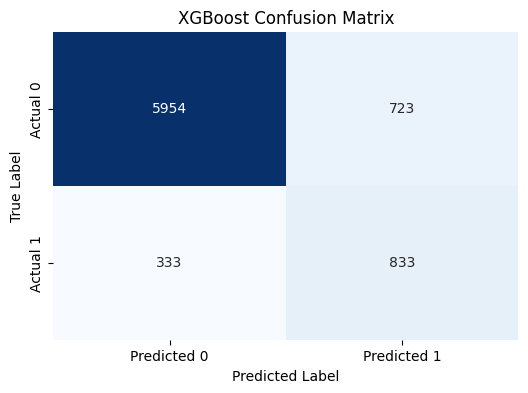

Best model: XGBoost Validation F1 Score: 0.850738023596592
Best model: XGBoost Validation F1 Score: 0.7652968113133504


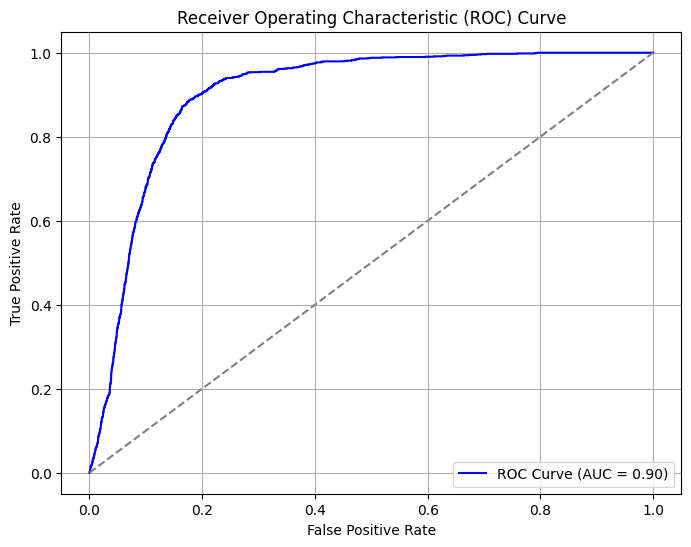

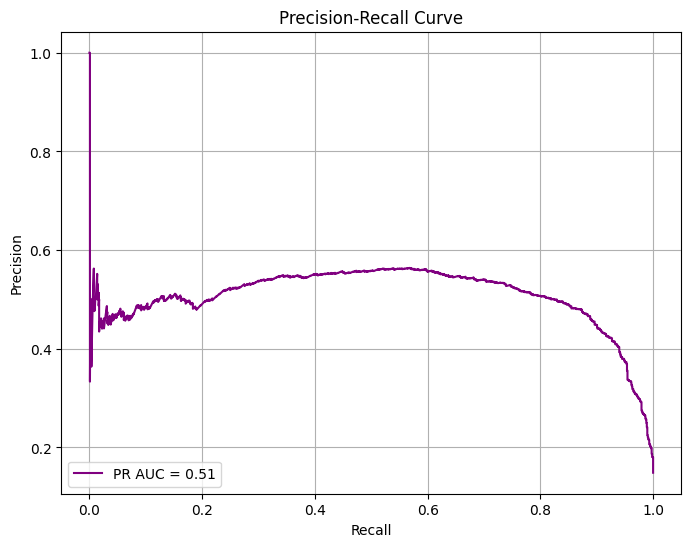

In [40]:
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
import xgboost as xgb
from scipy.stats import uniform, randint
import numpy as np


# Define the parameter space
param_distributions = {
    
    'max_depth': randint(4, 7),  # Shallow trees to combat overfitting
    'min_child_weight': randint(3, 6),  # Higher values prevent overfitting
    'learning_rate': uniform(0.01, 0.1),  # Smaller learning rate range
    
    'reg_alpha': uniform(0.1, 1.0),  # L1 regularization
    'reg_lambda': uniform(1.0, 5.0),  # L2 regularization
    'gamma': uniform(0.1, 0.5),  # Conservative split threshold
    
    'subsample': uniform(0.7, 0.3),  # Sample 70-100% of data
    'colsample_bytree': uniform(0.7, 0.3),  # Sample 70-100% of features
    
    'n_estimators': randint(200, 500)
}

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    random_state=42,
    tree_method='hist'
)

#stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring='f1',  
    cv=5, 
    verbose=0,
    random_state=42,
    n_jobs=-1 
   
)
eval_set = [(X_train_upsampled, y_train_upsampled), (X_val_transformed, y_val)]
random_search.fit(X_train_upsampled, y_train_upsampled) #,eval_set=eval_set,verbose=False,eval_metric=["auc","logloss"]
best_model = random_search.best_estimator_
y_val_pred_gxgb=best_model.predict(X_val_transformed)
y_val_proba_gxbg=best_model.predict_proba(X_val_transformed)
print("XGBoost Validation F1 Score:", f1_score(y_val,y_val_pred_gxgb,average='macro'))
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

xgb_grid_confusion = confusion_matrix(y_val, y_val_pred_gxgb)
plot_confusion_matrix(xgb_grid_confusion, title='XGBoost Confusion Matrix')

print("Best model: XGBoost Validation F1 Score:", f1_score(y_train, best_model.predict(X_train_transformed), average='macro'))
print("Best model: XGBoost Validation F1 Score:", f1_score(y_val, best_model.predict(X_val_transformed), average='macro'))

plot_roc_curve(y_val,y_val_proba_gxbg[:,1])
plot_pr_curve(y_val,y_val_proba_gxbg[:,1])

- **XGBoost with RandomizedSearchCV** delivers an F1 validation score of **0.7672**, showing a strong balance between precision and recall.
- **Parameter tuning** using randomized search resulted in finding optimal values for parameters like `max_depth`, `learning_rate`, `reg_alpha`, and `subsample` which help to control overfitting and improve model performance.
- **Cross-validation with 5-fold** helps assess the model’s robustness, ensuring it performs well across different subsets of the data.
- **Strong regularization** focus (with `reg_alpha` and `reg_lambda`) prevents overfitting, balancing the bias-variance tradeoff effectively.
- **AUC and log-loss metrics** used during evaluation provide additional insights into model performance beyond the F1 score, focusing on overall model calibration and uncertainty.

In [41]:
from sklearn.metrics import classification_report
print('XGB',classification_report(y_val,y_val_pred_xgb))
print('BEST XGB Randomized search',classification_report(y_val,best_model.predict(X_val_transformed)))
print('RandomForest',classification_report(y_val,y_val_pred_rf
                           ))

XGB               precision    recall  f1-score   support

           0       0.95      0.89      0.92      6677
           1       0.54      0.73      0.62      1166

    accuracy                           0.87      7843
   macro avg       0.74      0.81      0.77      7843
weighted avg       0.89      0.87      0.88      7843

BEST XGB Randomized search               precision    recall  f1-score   support

           0       0.95      0.89      0.92      6677
           1       0.54      0.71      0.61      1166

    accuracy                           0.87      7843
   macro avg       0.74      0.80      0.77      7843
weighted avg       0.89      0.87      0.87      7843

RandomForest               precision    recall  f1-score   support

           0       0.94      0.89      0.92      6677
           1       0.53      0.70      0.60      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.79      0.76      7843
weighted avg       0.88      0

loss curve from training a machine learning model, displaying both training loss (blue line) and validation loss (orange line) over approximately 450 epochs.

There are several key observations that indicate this model is experiencing overfitting:

1. Diverging Lines: The training loss (blue) continues to decrease steadily throughout training, while the validation loss (orange) initially decreases but then begins to increase and plateau after around epoch 50.

2. Performance Gap: There's a growing gap between training and validation loss - the training loss keeps improving (decreasing) while the validation loss gets worse (increases), which is a classic sign of overfitting.

3. Early Minimum: The validation loss reaches its minimum point relatively early in training (around epoch 50) and then starts to increase, suggesting this would have been a good point for early stopping.

To address this overfitting, several techniques could be considered:
- Implementing early stopping around epoch 50
- Adding regularization (L1/L2)
- Using dropout
- Reducing model complexity
- Increasing the training data
- Using data augmentation


XGBoost Validation F1 Score: 0.7754120450419784
Best parameters: {'colsample_bytree': 0.8123620356542087, 'gamma': 0.5753571532049581, 'learning_rate': 0.07419939418114051, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 202, 'reg_alpha': 0.45583275285359115, 'reg_lambda': 1.4998745790900143, 'scale_pos_weight': 3, 'subsample': 0.9598528437324805}
Best cross-validation score: 0.6857094274416594


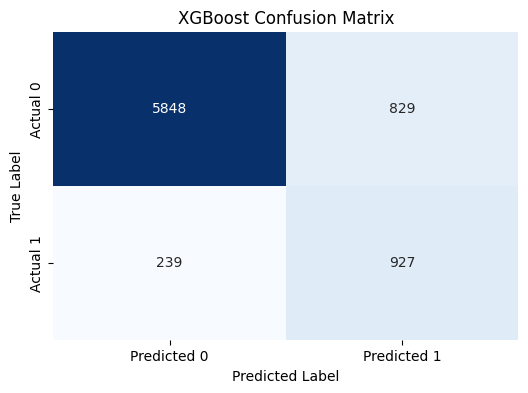

Best model: XGBoost Validation F1 Score: 0.853054357899515
Best model: XGBoost Validation F1 Score: 0.7754120450419784


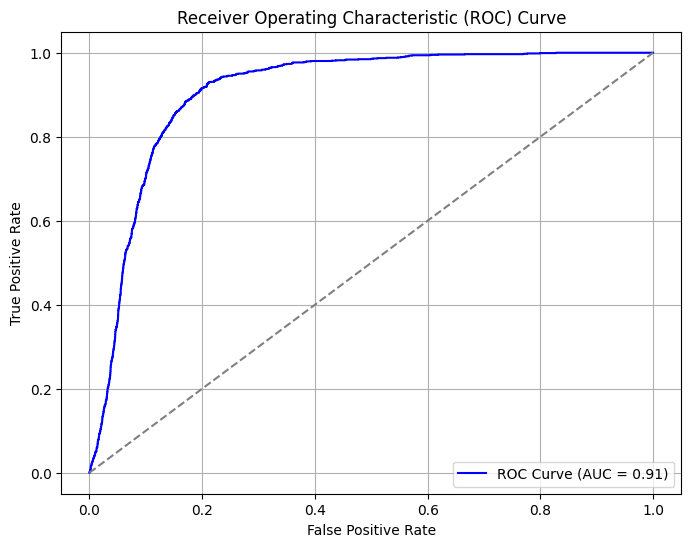

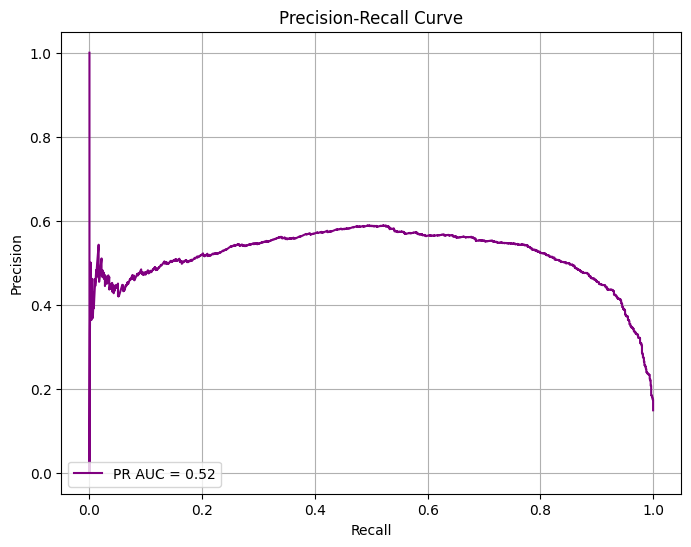

In [42]:
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
import xgboost as xgb
from scipy.stats import uniform, randint
import numpy as np
from sklearn.metrics import f1_score



# Define the parameter space
param_distributions = {
    
    'max_depth': randint(2, 10),  # Shallow trees to combat overfitting
    'min_child_weight': randint(1, 8),  # Higher values prevent overfitting
    'learning_rate': uniform(0.001, 0.1),  # Smaller learning rate range
    
    'reg_alpha': uniform(0.01, 1.0),  # L1 regularization
    'reg_lambda': uniform(1.0, 5.0),  # L2 regularization
    'gamma': uniform(0.1, 0.5),  # Conservative split threshold
    
    'subsample': uniform(0.7, 0.3),  # Sample 70-100% of data
    'colsample_bytree': uniform(0.7, 0.3),  # Sample 70-100% of features
    
    'n_estimators': randint(100, 500),
    'scale_pos_weight':[1,2,3,4,5]
}

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    random_state=42,
    tree_method='hist'
)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring='f1',  
    cv=stratified_kfold, 
    verbose=0,
    random_state=42,
    n_jobs=-1
   
)
eval_set = [(X_train_transformed, y_train), (X_val_transformed, y_val)]
random_search.fit(X_train_transformed, y_train) #,eval_set=eval_set,verbose=False,eval_metric=["auc","logloss"]
best_model = random_search.best_estimator_
y_val_pred_gxgb=best_model.predict(X_val_transformed)
y_val_proba_gxbg=best_model.predict_proba(X_val_transformed)
print("XGBoost Validation F1 Score:", f1_score(y_val,y_val_pred_gxgb,average='macro'))
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

xgb_grid_confusion = confusion_matrix(y_val, y_val_pred_gxgb)
plot_confusion_matrix(xgb_grid_confusion, title='XGBoost Confusion Matrix')

print("Best model: XGBoost Validation F1 Score:", f1_score(y_train, best_model.predict(X_train_transformed), average='macro'))
print("Best model: XGBoost Validation F1 Score:", f1_score(y_val, best_model.predict(X_val_transformed), average='macro'))

plot_roc_curve(y_val,y_val_proba_gxbg[:,1])
plot_pr_curve(y_val,y_val_proba_gxbg[:,1])

## Comparing classifiers

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

def plot_multiple_roc_curves(y_true, *y_probs, labels):
    # Apply a Seaborn theme
    sns.set(style="whitegrid")
    
    # Initialize figure for ROC curves
    plt.figure(figsize=(10, 8))

    # Iterate over each set of predicted probabilities
    for y_pred_prob, label in zip(y_probs, labels):
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        auc_score = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")

    # Plot chance line
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Comparison")
    plt.legend(loc="lower right")
    plt.show()

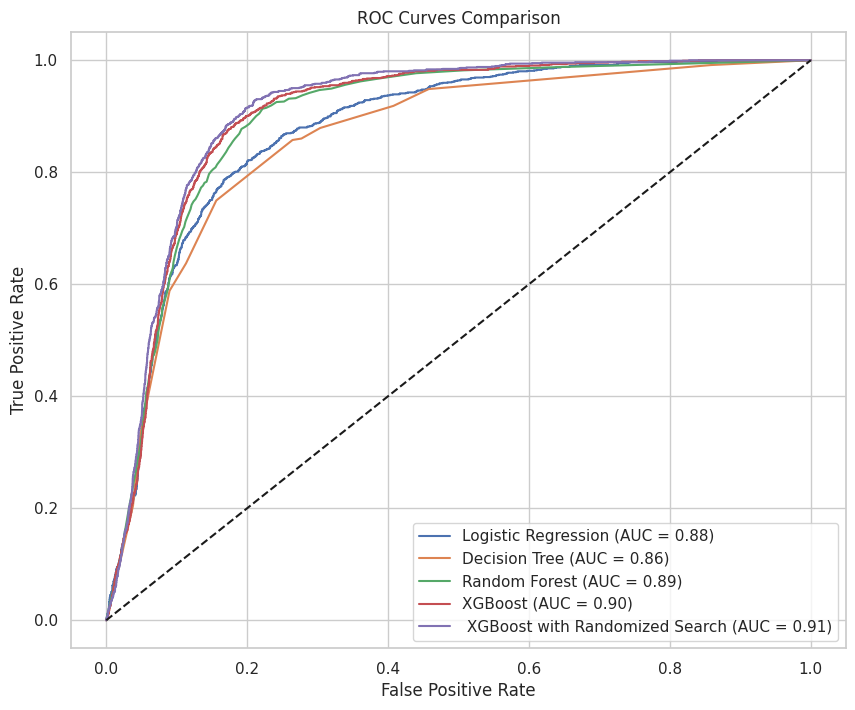

In [44]:
# Example usage
plot_multiple_roc_curves(
    y_val,
    y_pred_log_probs[:, 1],
    y_val_dt_probs[:, 1],
    y_val_rf_probs[:, 1],
    y_val_xgb_probs[:, 1],
    y_val_proba_gxbg[:, 1],
    labels=["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost", " XGBoost with Randomized Search"]
)


In [45]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

def calculate_metrics_df(y_true, *y_preds, labels):
    
    metrics_list = []


    for y_pred, label in zip(y_preds, labels):
        # Compute metrics
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred,average="macro")
        auc_score = roc_auc_score(y_true, y_pred)

       
        metrics_list.append({
            "Model": label,
            "Precision": precision,
            "Recall": recall,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "AUC Score": auc_score
        })

   
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df

metrics_df = calculate_metrics_df(
    y_val,
    y_pred_log_reg,
    y_val_dt,
    y_val_pred_rf,
    y_val_pred_xgb,
    y_val_pred_gxgb,
    labels=["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost", "XGBoost with Randomized Search"]
)

print(metrics_df)

                            Model  Precision    Recall  Accuracy  F1 Score  \
0             Logistic Regression   0.463542  0.763293  0.833482  0.736574   
1                   Decision Tree   0.455921  0.749571  0.829785  0.730527   
2                   Random Forest   0.529373  0.695540  0.862808  0.759170   
3                         XGBoost   0.539432  0.733276  0.867270  0.770556   
4  XGBoost with Randomized Search   0.527904  0.795026  0.863828  0.775412   

   AUC Score  
0   0.804516  
1   0.796682  
2   0.793779  
3   0.811973  
4   0.835434  


In [46]:
predictions=best_model.predict(df_test_transformed)


predictions_mapped = ['yes' if pred == 1 else 'no' for pred in predictions]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': range(len(predictions)),  
    'target': predictions_mapped             
})


submission_df.to_csv('submission.csv', index=False)
(predictions==0).sum()

7750